# Proyecto_02: Análisis de mercado inmobiliario 

**Ingeniería de features, Modelos avanzados e Interpretación de modelos**


## Objetivo: mejorar modelo Proyecto_01

**Modelo predictivo valor propiedades (departamento, PH y casa) en CABA. Preprocesamiento y modelos avanzados**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set()
from scipy import stats
from scipy.stats import norm


Bad key "text.kerning_factor" on line 4 in
C:\Users\BagattinMarciano\miniconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
def with_hue(plot, feature, Number_of_categories, hue_categories):
    a = [p.get_height() for p in plot.patches]
    patch = [p for p in plot.patches]
    for i in range(Number_of_categories):
        total = feature.value_counts().values[i]
        for j in range(hue_categories):
            percentage = '{:.1f}%'.format(100 * a[(j*Number_of_categories + i)]/total)
            x = patch[(j*Number_of_categories + i)].get_x() + patch[(j*Number_of_categories + i)].get_width() / 2
            y = patch[(j*Number_of_categories + i)].get_y() + patch[(j*Number_of_categories + i)].get_height() 
            ax.annotate(percentage, (x, y), size = 12, ha = 'center', xycoords = 'data') 
    

def without_hue(plot, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12, ha ='center' , xycoords = 'data')

## Drop inicial de columnas, y filtro de inconsistencias

Dado que el objeto del proyecto 2 es comparar el desempeño de nuevos modelos incorporando lo aprendido en bloque 2, debemos trabajar con la misma base que utilizamos en el proyecto 1, es decir: Depto, PH y Casa, en la CABA.

In [4]:
# Cargamos el dataset
data = pd.read_csv ('DS_Proyecto_01_Datos_Properati.csv')

#Saco instancias que no se ajustan al objeto del proyecto
data = data[(data['l2'] == "Capital Federal") & ((data['property_type'] == "Departamento")\
| (data['property_type'] == "Casa") | (data['property_type'] == "PH"))]

In [7]:
data.shape

(91485, 19)

Saco columnas con las que no voy a trabajar. Algunas adoptan un único valor. Es el caso de 'l1' (país: Argentina), 'l2' (ya filtramos dejando sólo CABA), 'currency' (moneda:dólar), y 'operation_type' (tipo de operación: venta). Vamos a quitarlas, y pasaremos a usarlas para describir el modelo. Es decir, el modelo que obtendremos será para predecir el valor *en dólares* de propiedades *a la venta* en Argentina (CABA, en nuestro caso).

También quitaremos 'start_date', 'end_date', 'created_on'. Con 'lat', 'lon' ya trabajé en proyecto_01.

Por último, quitaremos 'title' y 'description', que adoptan muchos valores diferentes de muy baja frecuencia, y que no nos aportan info importante.

In [8]:
data.drop(['start_date', 'end_date', 'created_on', 'lat', 'lon', 'l1', 'l2', 'currency', 'title',
           'description', 'operation_type'], axis=1, inplace=True)

También aplicaré filtros para sacar inconsistencias, previo al preprosesamiento

<function matplotlib.pyplot.show(*args, **kw)>

<Figure size 1728x432 with 0 Axes>

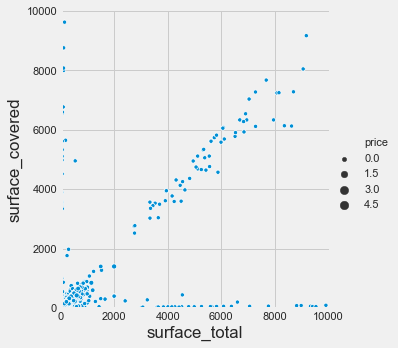

In [9]:
plt.figure(figsize = (12*2,6))
ax = sns.relplot(x="surface_total", y="surface_covered", size='price', data=data, palette="ch:r=-.5,l=.75")
plt.xlim (0,10000)
plt.ylim (0,10000)

plt.show

In [10]:
mask_incons = data[(data['surface_total'] < data ['surface_covered']) | (data['rooms'] < data ['bedrooms'])]
mask_incons.shape

(822, 8)

In [11]:
i1 = data[((data.surface_total < data.surface_covered))].index

In [12]:
data.drop((i1), inplace=True)

In [13]:
mask_incons_verif = data[(data['surface_total'] < data ['surface_covered'])]
mask_incons_verif

,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type


<function matplotlib.pyplot.show(*args, **kw)>

<Figure size 1728x432 with 0 Axes>

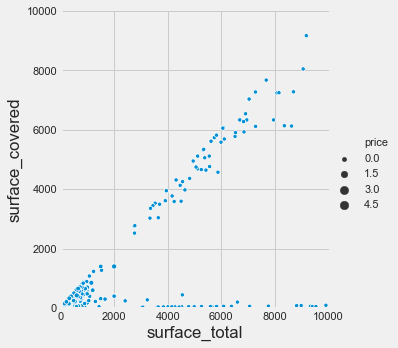

In [14]:
plt.figure(figsize = (12*2,6))
ax = sns.relplot(x="surface_total", y="surface_covered", size='price', data=data, palette="ch:r=-.5,l=.75")
plt.xlim (0,10000)
plt.ylim (0,10000)

plt.show

In [15]:
i2 = data[((data.rooms < data.bedrooms))].index

In [16]:
data.drop((i2), inplace=True)

In [17]:
data.shape

(90663, 8)

Arranco con un raw data de 90663 instancias y ocho columnas

# ANÁLISIS EXPLORATORIO DE DATOS

Este apartado está más desarrollado en proyecto_01. Reitero lo más importantes para hacer hincapié sobre lo que me interesa. 

In [18]:
# Un describe sobre todo el dataset
data.describe(include='all').round(2)

,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type
count,90663,90663.00,90663.00,88500.00,81747.00,81429.00,90663.00,90663
unique,57,NaN,NaN,NaN,NaN,NaN,NaN,3
top,Palermo,NaN,NaN,NaN,NaN,NaN,NaN,Departamento
freq,12958,NaN,NaN,NaN,NaN,NaN,NaN,78455
mean,NaN,2.96,1.96,1.56,112.74,92.18,259761.58,NaN
std,NaN,1.30,1.06,0.86,985.52,769.14,323018.68,NaN
min,NaN,1.00,0.00,1.00,12.00,1.00,6000.00,NaN
25%,NaN,2.00,1.00,1.00,49.00,44.00,121600.00,NaN
50%,NaN,3.00,2.00,1.00,71.00,63.00,175000.00,NaN
75%,NaN,4.00,3.00,2.00,111.00,96.00,279000.00,NaN


## Análisis de variables/atributos

### Variables cualitativas

Empezamos analizando instancias por tipo de propiedad, mediante tabla y gráficamente.

In [19]:
# Contamos cantidad de propiedades según tipo
data['property_type'].value_counts()

Departamento    78455
PH               9707
Casa             2501
Name: property_type, dtype: int64

In [20]:
# Repetimos análisis en términos porcentuales
(data['property_type'].value_counts())/len(data['property_type'])

Departamento    0.865347
PH              0.107067
Casa            0.027586
Name: property_type, dtype: float64

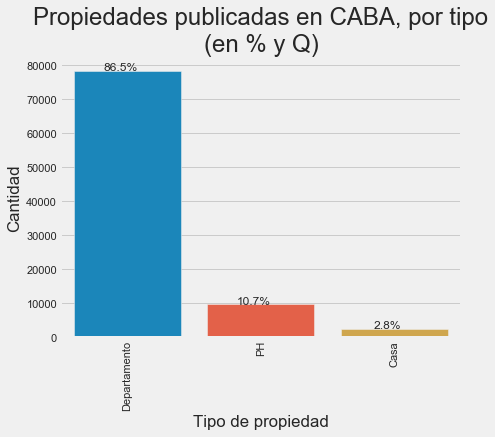

In [21]:
# Análisis anterior en un gráfico
plt.figure(figsize = (6.4, 4.8)) 
ax = sns.countplot (data = data, x = 'property_type', order = data['property_type'].value_counts().index)
plt.title('Propiedades publicadas en CABA, por tipo\n(en % y Q)', fontsize=24 )
plt.xticks(rotation = 90)
plt.xlabel("Tipo de propiedad")
plt.ylabel("Cantidad")

without_hue(ax,data.property_type)
#plt.savefig('Cantidad de propiedades (por tipo).png', bbox_inches='tight', dpi = 400)
plt.show()

Ahora, vamos a mirar la distribución por barrio

In [22]:
data['l3'].value_counts()

Palermo                 12958
Almagro                  7472
Belgrano                 6815
Caballito                6534
Villa Crespo             6410
Recoleta                 5833
Villa Urquiza            3282
Barrio Norte             3184
Balvanera                2897
Flores                   2493
Nuñez                    1946
Puerto Madero            1743
Colegiales               1574
San Cristobal            1502
Villa Devoto             1380
Villa del Parque         1331
Parque Centenario        1314
Saavedra                 1095
Paternal                 1026
Liniers                  1017
San Telmo                1013
Floresta                  922
Villa Luro                920
Boedo                     909
Monserrat                 816
Retiro                    813
Parque Chacabuco          811
San Nicolás               792
Las Cañitas               788
Once                      770
Barracas                  742
Chacarita                 735
Mataderos                 720
Villa Puey

In [23]:
#Vamos a mirar 'l3' más detenidamente. Cuantos barrios distintos hay?
data.l3.describe()

count       90663
unique         57
top       Palermo
freq        12958
Name: l3, dtype: object

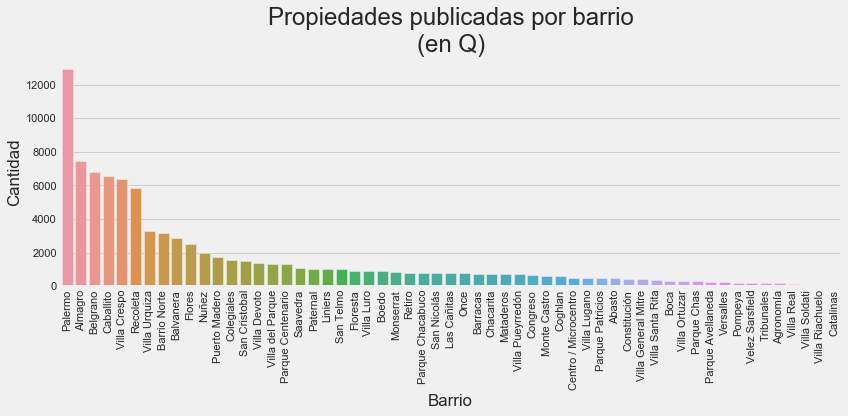

In [24]:
plt.figure(figsize = (12,6))
ax = sns.countplot(data = data, x = 'l3', order = data['l3'].value_counts().index)
plt.xticks(rotation = 90)
plt.title('Propiedades publicadas por barrio\n(en Q)', fontsize = 24)

plt.ylabel('Cantidad')
plt.xlabel('Barrio')
plt.tight_layout()
#without_hue (ax, data.l3)
#plt.savefig('Cantidad de propiedades (por barrio).png', bbox_inches='tight', dpi = 400)
plt.show()

### Variables cuantitativas

Vamos a realizar análisis de distribuciones para conocer mejor las variables

In [25]:
data.describe().round(2)

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,90663.00,90663.00,88500.00,81747.00,81429.00,90663.00
mean,2.96,1.96,1.56,112.74,92.18,259761.58
std,1.30,1.06,0.86,985.52,769.14,323018.68
min,1.00,0.00,1.00,12.00,1.00,6000.00
25%,2.00,1.00,1.00,49.00,44.00,121600.00
50%,3.00,2.00,1.00,71.00,63.00,175000.00
75%,4.00,3.00,2.00,111.00,96.00,279000.00
max,26.00,15.00,14.00,126062.00,126062.00,32434232.00


PRIMER ANÁLISIS PREVIO: el describe ya nos muestra a simple vista que la mayoría de las variables muestran valores máximos que están a varios desvíos estandar de la su media. Si bien la existencia de outliers nos dificultará la visualización, preferimos dejarlos, y recién tratarlos cuando entremos en el apartado de preprocesamiento.

#### Precio

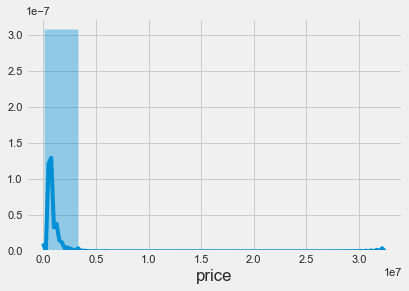

In [26]:
sns.distplot(data['price'], bins = 10)

Vamos a colocar una máscara para poder visualizar.

In [27]:
mask1 = data [(data['price']<= 1000000)]

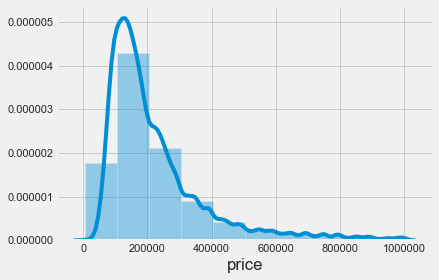

In [28]:
sns.distplot(mask1['price'], bins = 10)

¿Como es su función de densidad? Parece una chi2, se ve claramente el sesgo hacia la derecha. Ahora miremos distribución del precio según tipo de propiedad, por boxplot y boxenplot.

<Figure size 288x216 with 0 Axes>

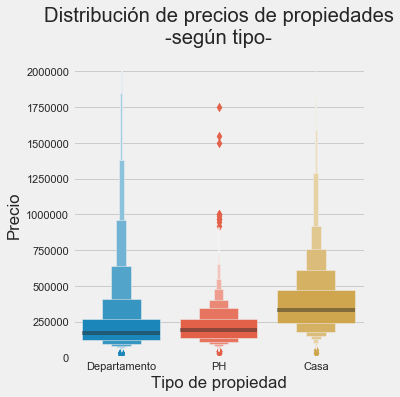

<Figure size 288x216 with 0 Axes>

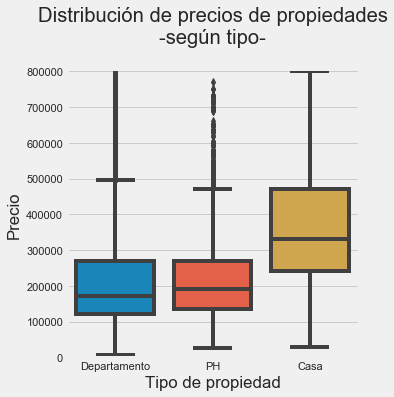

In [29]:
plt.figure(figsize = (4,3))
#plt.subplot(1,2,1)
sns.catplot(x='property_type', y='price', kind="boxen", data=data)
plt.ylim (0,2000000)
plt.title ('Distribución de precios de propiedades\n-según tipo-\n')
plt.ylabel("Precio")
plt.xlabel("Tipo de propiedad")

plt.figure(figsize = (4,3))
#plt.subplot(1,2,2)
sns.catplot(x='property_type', y='price', kind="box", data=data, showfliers = True)
plt.ylim (0,800000)
plt.title ('Distribución de precios de propiedades\n-según tipo-\n')
plt.ylabel("Precio")
plt.xlabel("Tipo de propiedad")

plt.show()

Análizando por tipo de propiedad, vemos que el precio de departamentos y PH tienen funciones de densidad similares entre ellas, y diferentes frente a Casa. Tenemos que mirar la distribución de los atributos, para entender si ellas explican esta diferencia.

#### Ambientes, dormitorios y baños

Miremos la distribución de ambientes, dormitorios y baños, según tipo de propiedad

Text(0, 0.5, 'Cantidad de propiedades')

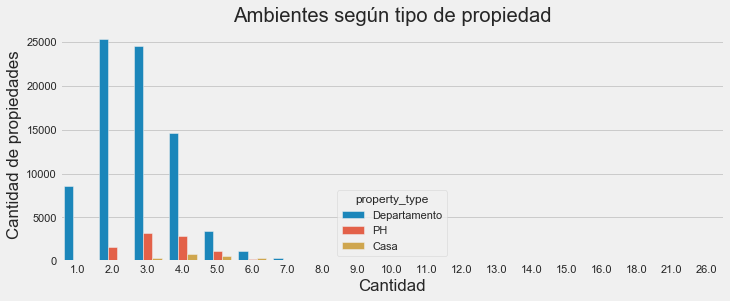

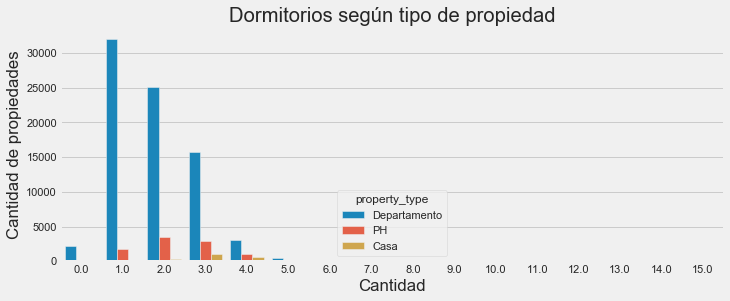

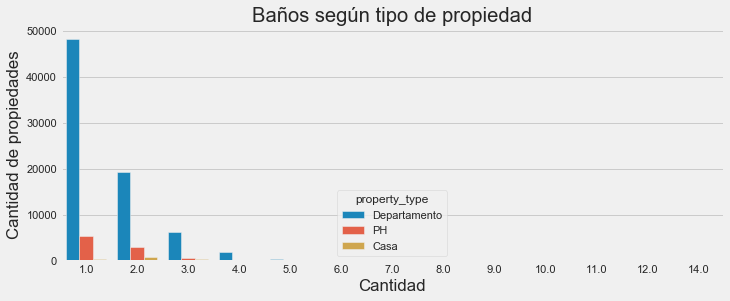

In [30]:
plt.figure(figsize = (12*3,4))

plt.subplot(1,3,1)
sns.countplot(data = data, x = 'rooms', hue = 'property_type')
plt.title('Ambientes según tipo de propiedad')
plt.xlabel('Cantidad')
plt.ylabel('Cantidad de propiedades')

plt.figure(figsize = (12*3,4))
plt.subplot(1,3,2)
sns.countplot(data = data, x = 'bedrooms', hue = 'property_type')
plt.title('Dormitorios según tipo de propiedad')
plt.xlabel('Cantidad')
plt.ylabel('Cantidad de propiedades')

plt.figure(figsize = (12*3,4))
plt.subplot(1,3,3)
sns.countplot(data = data, x = 'bathrooms', hue = 'property_type')
plt.title('Baños según tipo de propiedad')
plt.xlabel('Cantidad')
plt.ylabel('Cantidad de propiedades')

En relación a las distribución de precios según tipo de propiedad, acá se observa que la moda de ambiente, dormitorio y baño, es mayor para Casa que para los otros dos tipos de propiedad.

#### Superficie total y cubierta

Vamos a mirar función de densidad, boxenplot y boxplot.

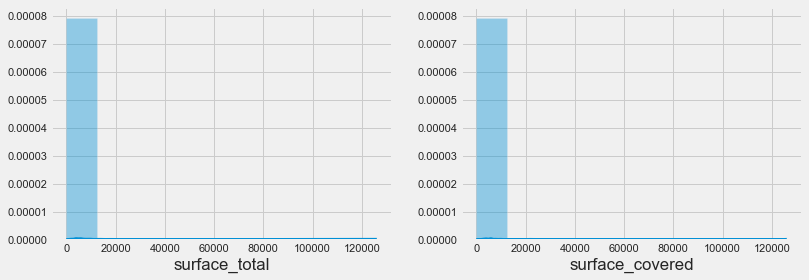

In [31]:
plt.figure(figsize=(3*4,4))
plt.subplot(1,2,1)
sns.distplot(data['surface_total'], bins = 10)

plt.subplot(1,2,2)
sns.distplot(data['surface_covered'], bins = 10)

Le agregamos una máscara para ayudarnos a la visualización.

In [32]:
mask2 = data [(data['surface_total']<= 400) & (data['surface_covered']<=300)]

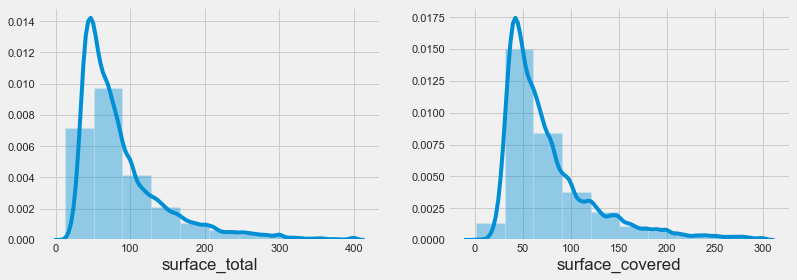

In [33]:
plt.figure(figsize=(3*4,4))
plt.subplot(1,2,1)
sns.distplot(mask2['surface_total'], bins = 10)

plt.subplot(1,2,2)
sns.distplot(mask2['surface_covered'], bins = 10)

Presentan distribución chi-cuad.

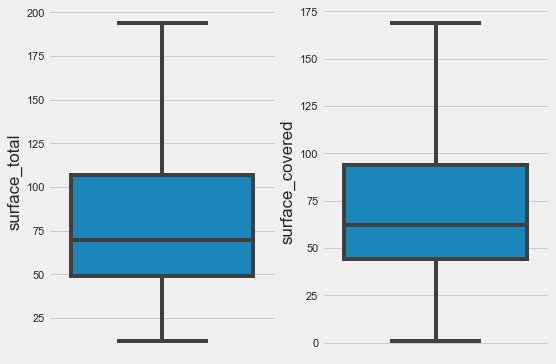

In [34]:
plt.figure(figsize=(4*2,6))
plt.subplot(1,2,1)
sns.boxplot(mask2['surface_total'], orient='v', showfliers=False)

plt.subplot(1,2,2)
sns.boxplot(mask2['surface_covered'], orient='v', showfliers=False)

Mismo análisis, pero por tipo de propiedad

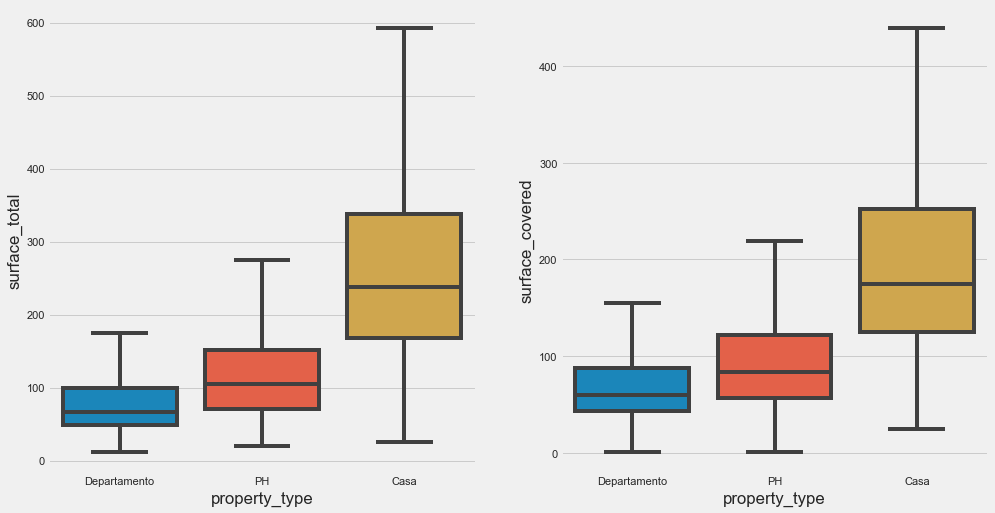

In [35]:
plt.figure(figsize=(3*5,8))
plt.subplot(1,2,1)
sns.boxplot(x='property_type', y='surface_total', data=data, showfliers=False)

plt.subplot(1,2,2)
sns.boxplot(x='property_type', y='surface_covered', data=data, showfliers=False)

Aquí confirmo lo anterior sobre la diferencia en la distribución de precios según tipos de propiedad. Esta es mayor para las casas, pero también lo son todos los demás atributos. Podemos pensar que el tipo de propiedad, dependiendo del resto de atributos, no tengo valor explicativo por sí mismo.

#### Correlación: método de Spearman

Comenzamos mirando correlación global (para todo tipo de propiedad y región)

In [36]:
corr1 = data.corr(method= 'spearman')

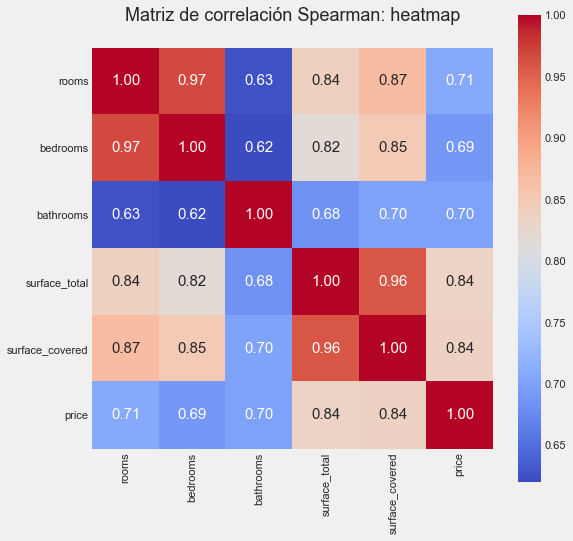

In [37]:
plt.figure(figsize=(8,8))
sns.heatmap(corr1, cbar = True, square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
#xticklabels= corr1.drop(['lat', 'lon'], axis=1).columns,
#yticklabels= corr1.drop(['lat', 'lon'], axis=1).columns,
cmap= 'coolwarm')
plt.title('Matriz de correlación Spearman: heatmap\n', fontsize = 18)
plt.xticks(rotation = 90)
#plt.savefig('Matriz de correlación: heatmap.png', dpi = 800)
plt.show()

Rooms-Bedrooms con correlación muy alta. Junto a bathrooms, las tres tienen correlación similar con precio. Globalmente, las mas correlacionadas a la variable dependiente son superficie cubierta y total, muy correlacionadas entre ellas, desde luego. Puede que excluya alguna manualmente, o use PCA (reducción de dimensionalidad).

Ahora, correlaciones (sin outliers), según tipo de propiedad.

In [38]:
data_Dep = data[(data['property_type']== 'Departamento')]
data_PH = data[(data['property_type']== 'PH')]
data_Casa = data[(data['property_type']== 'Casa')]

In [39]:
corr_data_Dep = data_Dep.corr(method= 'spearman')
corr_data_PH = data_PH.corr(method= 'spearman')
corr_data_Casa = data_Casa.corr(method= 'spearman')

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]), <a list of 6 Text xticklabel objects>)

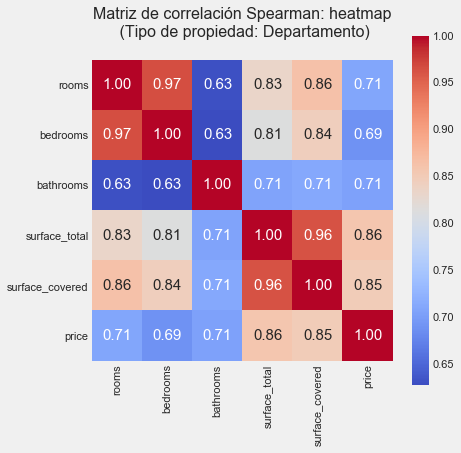

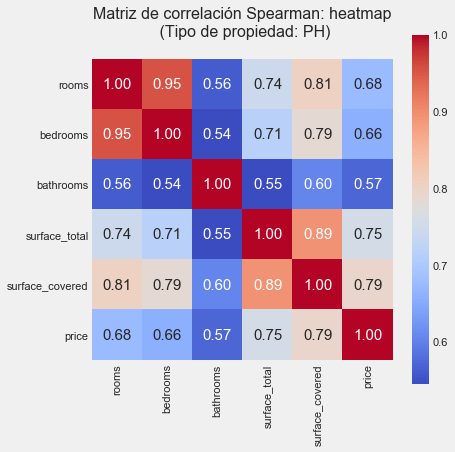

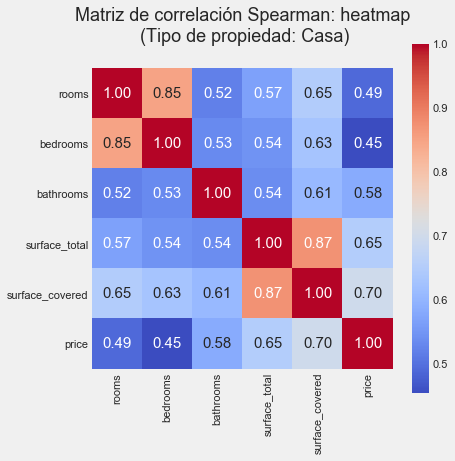

In [40]:
plt.figure(figsize=(6,6))
sns.heatmap(corr_data_Dep, cbar = True, square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
#xticklabels= data_Dep.drop(['property_type'], axis=1).columns,
#yticklabels= data_Dep.drop(['property_type'], axis=1).columns,
cmap= 'coolwarm')
plt.title('Matriz de correlación Spearman: heatmap\n (Tipo de propiedad: Departamento)\n', fontsize = 16)
plt.xticks(rotation = 90)

plt.figure(figsize=(6,6))
sns.heatmap(corr_data_PH, cbar = True, square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
#xticklabels= data_PH.drop(['property_type'], axis=1).columns,
#yticklabels= data_PH.drop(['property_type'], axis=1).columns,
cmap= 'coolwarm')
plt.title('Matriz de correlación Spearman: heatmap\n (Tipo de propiedad: PH)\n', fontsize = 16)
plt.xticks(rotation = 90)

plt.figure(figsize=(6,6))
sns.heatmap(corr_data_Casa, cbar = True, square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
#xticklabels= data_Casa.drop(['property_type'], axis=1).columns,
#yticklabels= data_Casa.drop(['property_type'], axis=1).columns,
cmap= 'coolwarm')
plt.title('Matriz de correlación Spearman: heatmap\n (Tipo de propiedad: Casa)\n', fontsize = 18)
plt.xticks(rotation = 90)

Es notable como se va reduciendo la correlación de todas las variables independientes respecto al precio, conforme nos movemos de Departamento a PH, y de PH a Casa. Alguna de las variables no analizadas acá (barrios, quizás), u otras no contenidas en el dataset (como la relación entre superficie cubierta y total, por ej), deberían ayudar a explicar este fenómeno. 

# PARTE A: TRANSFORMACIÓN DE DATOS

El preprocesamiento que sigue obedece a un proceso iterativo de ensayo-error 

## Tratamiento manual de outliers

### Ambientes, dormitorios y baños

Text(0, 0.5, 'Cantidad de propiedades')

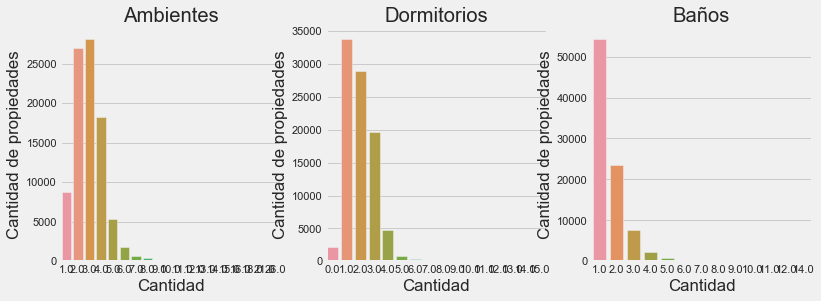

In [41]:
plt.figure(figsize = (4*3,4))

plt.subplot(1,3,1)
sns.countplot(data = data, x = 'rooms')
plt.title('Ambientes')
plt.xlabel('Cantidad')
plt.ylabel('Cantidad de propiedades')

plt.subplot(1,3,2)
sns.countplot(data = data, x = 'bedrooms')
plt.title('Dormitorios')
plt.xlabel('Cantidad')
plt.ylabel('Cantidad de propiedades')

plt.subplot(1,3,3)
sns.countplot(data = data, x = 'bathrooms')
plt.title('Baños')
plt.xlabel('Cantidad')
plt.ylabel('Cantidad de propiedades')

In [42]:
mask_i3 = data[(data['rooms'] > 8) | (data['bedrooms'] > 5) | (data['bathrooms'] > 4)]
mask_i3

,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type
0,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,Departamento
310,Puerto Madero,4.0,3.0,5.0,250.0,250.0,3390000.0,Departamento
325,Palermo,5.0,4.0,5.0,266.0,266.0,2200000.0,Departamento
327,Palermo,5.0,4.0,5.0,266.0,266.0,2200000.0,Departamento
456,Villa del Parque,10.0,8.0,4.0,2000.0,1400.0,5000000.0,Casa
...,...,...,...,...,...,...,...,...
146143,Palermo,8.0,3.0,6.0,301.0,239.0,900000.0,Departamento
146145,Palermo,8.0,3.0,5.0,301.0,239.0,1290000.0,Departamento
146181,Palermo,4.0,3.0,5.0,220.0,210.0,1470000.0,Departamento
146532,Palermo,6.0,4.0,6.0,326.0,326.0,2740000.0,Departamento


In [43]:
i3 = data[(data['rooms'] > 6) | (data['bedrooms'] > 4) | (data['bathrooms'] > 4)].index

In [44]:
data.drop((i3), inplace=True)

Text(0, 0.5, 'Cantidad de propiedades')

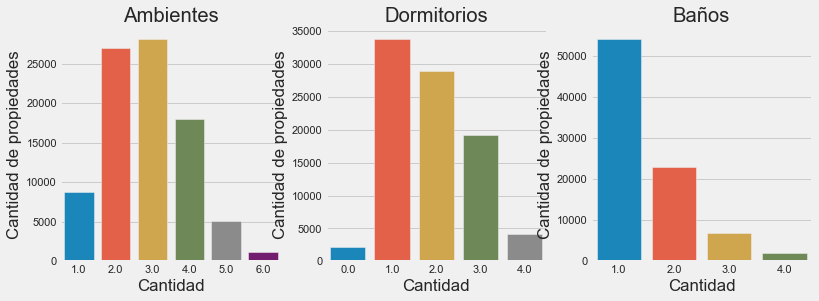

In [45]:
plt.figure(figsize = (4*3,4))

plt.subplot(1,3,1)
sns.countplot(data = data, x = 'rooms')
plt.title('Ambientes')
plt.xlabel('Cantidad')
plt.ylabel('Cantidad de propiedades')

plt.subplot(1,3,2)
sns.countplot(data = data, x = 'bedrooms')
plt.title('Dormitorios')
plt.xlabel('Cantidad')
plt.ylabel('Cantidad de propiedades')

plt.subplot(1,3,3)
sns.countplot(data = data, x = 'bathrooms')
plt.title('Baños')
plt.xlabel('Cantidad')
plt.ylabel('Cantidad de propiedades')

In [46]:
(data['property_type'].value_counts())/len(data['property_type'])

Departamento    0.872792
PH              0.104284
Casa            0.022923
Name: property_type, dtype: float64

In [47]:
data['property_type'].value_counts()

Departamento    76948
PH               9194
Casa             2021
Name: property_type, dtype: int64

### Superficies

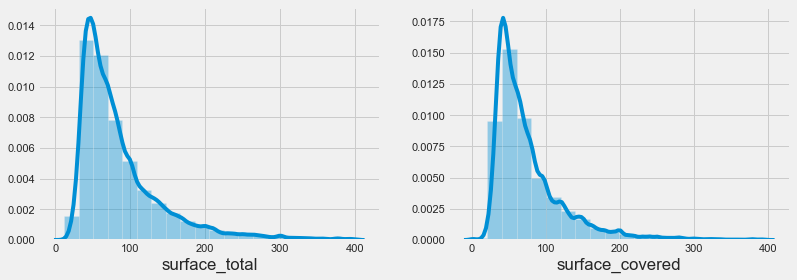

In [48]:
mask_sT400 = data[(data['surface_total'] < 400)]
mask_sC400 = data[(data['surface_covered'] < 400)]

plt.figure(figsize=(3*4,4))
plt.subplot(1,2,1)
sns.distplot(mask_sT400['surface_total'], bins = 20)

plt.subplot(1,2,2)
sns.distplot(mask_sC400['surface_covered'], bins = 20)

In [49]:
#reescribo el dataset; el filtrado por superficie total incluye a superficie cubierta
data = data[(data['surface_total'] <= 300)]

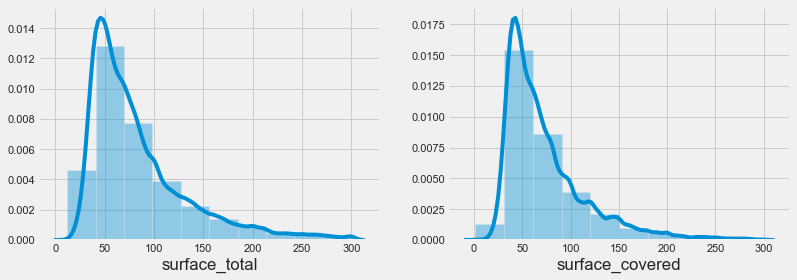

In [50]:
plt.figure(figsize=(3*4,4))
plt.subplot(1,2,1)
sns.distplot(data['surface_total'], bins = 10)

plt.subplot(1,2,2)
sns.distplot(data['surface_covered'], bins = 10)

In [51]:
data.describe().round(2)

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,78003.00,78003.00,77168.00,78003.00,77504.00,78003.00
mean,2.87,1.89,1.47,84.04,73.55,233325.85
std,1.08,0.89,0.72,50.48,42.47,238180.36
min,1.00,0.00,1.00,12.00,1.00,6000.00
25%,2.00,1.00,1.00,48.00,44.00,122000.00
50%,3.00,2.00,1.00,69.00,60.00,174250.00
75%,4.00,3.00,2.00,102.00,90.00,265000.00
max,6.00,4.00,4.00,300.00,300.00,32434232.00


### Precio

In [52]:
mask_highPrice = data [(data['price']>= 8000000)]
mask_highPrice.head(10)

,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type
76894,Palermo,1.0,1.0,4.0,43.0,43.0,32434232.0,Departamento


In [53]:
i4 = data[((data.price == 32434232.0))].index

In [54]:
data.drop((i4), inplace=True)

In [55]:
mask_lowPrice = data [(data['price']<= 10000)]
mask_lowPrice.head(10) 

,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type
10799,Parque Chacabuco,1.0,1.0,1.0,31.0,31.0,7500.0,Departamento
96337,Puerto Madero,5.0,3.0,3.0,195.0,195.0,6000.0,Departamento
117012,Puerto Madero,3.0,2.0,3.0,275.0,220.0,6000.0,Departamento


También voy quitar las propiedades con valor por debajo de U$S10K. 

In [56]:
i5 = data[((data.price <= 10000.0))].index

In [57]:
data.drop((i5), inplace=True)

In [58]:
data.describe().round(2)

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,77999.00,77999.00,77164.00,77999.00,77500.00,77999.00
mean,2.87,1.89,1.47,84.04,73.55,232921.74
std,1.08,0.89,0.72,50.47,42.46,208414.83
min,1.00,0.00,1.00,12.00,1.00,10500.00
25%,2.00,1.00,1.00,48.00,44.00,122000.00
50%,3.00,2.00,1.00,69.00,60.00,174500.00
75%,4.00,3.00,2.00,102.00,90.00,265000.00
max,6.00,4.00,4.00,300.00,300.00,4400007.00


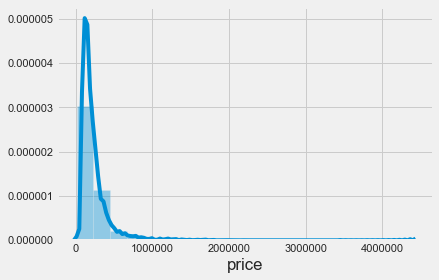

In [59]:
plt.figure(figsize=(6,4))
sns.distplot(data['price'], bins = 20)

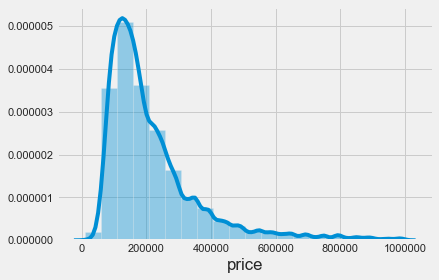

In [60]:
mask_highPrice1MM= data [(data['price'] < 1000000)]
plt.figure(figsize=(6,4))
sns.distplot(mask_highPrice1MM['price'], bins = 20)

In [61]:
i6 = data[((data.price > 800000.0))].index

In [62]:
data.drop((i6), inplace=True)

In [63]:
data.describe().round(2)

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,76227.00,76227.00,75402.00,76227.00,75737.00,76227.00
mean,2.83,1.87,1.44,81.16,70.76,210323.18
std,1.06,0.88,0.68,46.72,38.03,130926.11
min,1.00,0.00,1.00,12.00,1.00,10500.00
25%,2.00,1.00,1.00,48.00,43.00,120000.00
50%,3.00,2.00,1.00,68.00,60.00,170000.00
75%,4.00,2.00,2.00,100.00,86.00,258000.00
max,6.00,4.00,4.00,300.00,300.00,800000.00


## Encoding

**Tenemos dos variables categóricas a transformar, por diferentes estratégias:**
* 'property_type'; 
* 'l3'


### Get_dummies: tipos de propiedad

Para 'property_type', dado que sólo adquiere tres valores, hago dummies.

In [64]:
data = pd.get_dummies(data, columns=['property_type'])
data.head()

,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type_Casa,property_type_Departamento,property_type_PH
1,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,0,0,1
2,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,0,0,1
3,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,0,0,1
5,Villa Crespo,2.0,1.0,1.0,56.0,56.0,150000.0,0,0,1
6,Villa Crespo,2.0,1.0,1.0,70.0,70.0,159500.0,0,0,1


### Clustering y dummies: barrios

El tratamiento para 'l3' tiene que ser diferente, ya que admite 57 etiquetas diferentes. Lo ideal es, primero, tratar de agrupar barrios x algún criterio, para luego hacer dummies. Dada que el barrio influye en el valor de las propiedades (expresado en diferentes valores x metro2), lo lógico sería agruparlos por media de precio. Para ello, creo una variable de valor (en miles de dólares) por metro cuadrado. Luego le calculo la media por barrio, y hago clusterización para agrupar barrios con medias similares. Al final, hago dummies sobre los clusters resultantes.

**Construcción de nueva variable**
Primero voy a calcular el valor por m2, en miles. El denominador es un promedo de superficie cubierta y total.

In [65]:
#Calculo el valor del m2 para unificar
data['valor_m2_miles'] = (data.price/((data.surface_covered+data.surface_total)/2))/1000
data.head()

,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type_Casa,property_type_Departamento,property_type_PH,valor_m2_miles
1,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,0,0,1,2.484375
2,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,0,0,1,2.777778
3,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,0,0,1,4.370370
5,Villa Crespo,2.0,1.0,1.0,56.0,56.0,150000.0,0,0,1,2.678571
6,Villa Crespo,2.0,1.0,1.0,70.0,70.0,159500.0,0,0,1,2.278571


In [66]:
data.shape

(76227, 11)

Creo la nueva variable en que colocaré la media de precio por metro cuadrado que le corresponde al barrio en que se ubica la propiedad

In [67]:
data['valorMedio_M2_Barrio'] = data.groupby(['l3'])['valor_m2_miles'].transform('mean')
data

,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type_Casa,property_type_Departamento,property_type_PH,valor_m2_miles,valorMedio_M2_Barrio
1,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,0,0,1,2.484375,2.199881
2,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,0,0,1,2.777778,3.461578
3,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,0,0,1,4.370370,3.461578
5,Villa Crespo,2.0,1.0,1.0,56.0,56.0,150000.0,0,0,1,2.678571,2.543126
6,Villa Crespo,2.0,1.0,1.0,70.0,70.0,159500.0,0,0,1,2.278571,2.543126
...,...,...,...,...,...,...,...,...,...,...,...,...
146552,Palermo,4.0,2.0,3.0,159.0,98.0,539000.0,0,1,0,4.194553,3.461578
146553,Palermo,4.0,3.0,2.0,106.0,100.0,620000.0,0,1,0,6.019417,3.461578
146554,Palermo,4.0,3.0,3.0,175.0,111.0,570000.0,0,0,1,3.986014,3.461578
146555,Palermo,3.0,2.0,2.0,144.0,134.0,480000.0,0,0,1,3.453237,3.461578


In [68]:
data.valorMedio_M2_Barrio.unique()
#obtuvimos las 57 medias (una por cada barrio)

array([2.19988141, 3.46157828, 2.54312596, 1.94887421, 2.54156416,
       2.53194286, 2.18897705, 3.38984136, 2.54640179, 3.43785682,
       1.92081902, 3.35760459, 2.17783964, 2.6763669 , 2.56988928,
       2.46608522, 2.90383315, 2.26440979, 3.21019491, 3.8325526 ,
       2.35176068, 2.96864833, 2.52564223, 2.15379548, 1.85294037,
       2.08646601, 3.00087799, 2.12829956, 5.53689799, 2.05480068,
       2.68577947, 2.03330504, 2.3586086 , 2.15933603, 2.95929133,
       2.19246028, 2.23083155, 2.66696539, 2.22986924, 2.41328627,
       1.28799225, 1.72325503, 1.8986587 , 2.50341117, 2.20043586,
       1.72179417, 1.41758275, 2.44708016, 2.40856929, 2.12463158,
       1.95037332, 2.44064022, 2.09362688, 2.03480078, 1.6610717 ,
       2.08646119, 0.90882789])

Voy a crear la matriz con que alimento al modelo de agrupamiento

In [69]:
data.columns

Index(['l3', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered', 'price', 'property_type_Casa',
       'property_type_Departamento', 'property_type_PH', 'valor_m2_miles',
       'valorMedio_M2_Barrio'],
      dtype='object')

In [70]:
X_valorMedio = data.drop(['l3', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered', 'price', 'property_type_Casa',
       'property_type_Departamento', 'property_type_PH', 'valor_m2_miles'], axis=1)

In [71]:
X_valorMedio_2d = X_valorMedio.values.reshape(-1,1)

In [72]:
from sklearn.cluster import DBSCAN

In [73]:
#db_1 = DBSCAN(eps=0.2, min_samples=2, n_jobs=-1)
#db_1.fit(X_valorMedio)

In [74]:
#con la 2_d
db_1 = DBSCAN(eps=0.2, min_samples=2, n_jobs=-1)
db_1.fit(X_valorMedio_2d)

DBSCAN(algorithm='auto', eps=0.2, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=2, n_jobs=-1, p=None)

In [75]:
#Consultamos las etiquetas
labels_1 = db_1.labels_

#Number of clusters in labels, ignoring noise if present.
n_clusters_1 = len(set(labels_1)) - (1 if -1 in labels_1 else 0)
n_noise_1 = list(labels_1).count(-1)

In [76]:
print('Estimated number of clusters: %d' % n_clusters_1)
print('Estimated number of noise points: %d' % n_noise_1)

Estimated number of clusters: 7
Estimated number of noise points: 0


Text(0.5, 1.0, 'Points by cluster')

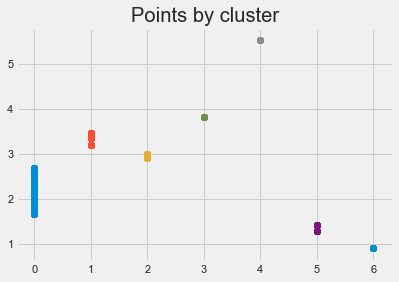

In [77]:
# Plot each class as a separate colour
n_clusters = 7 
for n in range(n_clusters):
    # Filter data points to plot each in turn.
    ys = X_valorMedio_2d[labels_1==n ]
    xs = labels_1[labels_1==n ]

    plt.scatter(xs, ys)

plt.title("Points by cluster")

Obtengo 7 clusters. El problema es que uno de ellos es muy heterogéneo. Quizás sea mejor forzar algunos clusters más, mediante K-Means

In [78]:
from sklearn.cluster import KMeans

# Especificamos el numero adecuado de clusters
kmeans_1 = KMeans(n_clusters=10, random_state=42, n_jobs=-1)

In [79]:
kmeans_1.fit(X_valorMedio_2d)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [80]:
y_kmeans = kmeans_1.predict(X_valorMedio_2d)

centros_1 = kmeans_1.cluster_centers_
print(centros_1)

[[2.67540991]
 [3.42914576]
 [2.16150213]
 [5.53689799]
 [2.95655739]
 [2.51630278]
 [1.87166935]
 [3.21019491]
 [1.29472272]
 [3.8325526 ]]


In [81]:
#Consultamos las etiquetas
etiquetas_1 = kmeans_1.labels_

#Number of clusters in labels, ignoring noise if present.
n_clusters_1 = len(set(etiquetas_1)) - (1 if -1 in etiquetas_1 else 0)
n_noise_1 = list(etiquetas_1).count(-1)

In [82]:
print('Estimated number of clusters: %d' % n_clusters_1)
print('Estimated number of noise points: %d' % n_noise_1)

Estimated number of clusters: 10
Estimated number of noise points: 0


Text(0.5, 1.0, 'Points by cluster')

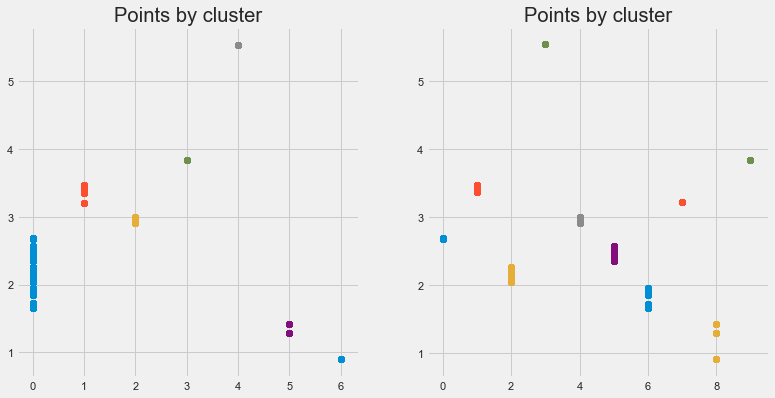

In [83]:
# Grafico ambos p/comparar
plt.figure(figsize=(6*2,6))
plt.subplot(1,2,1)
n_clusters = 7 
for n in range(n_clusters):
    # Filter data points to plot each in turn.
    ys = X_valorMedio_2d[labels_1==n ]
    xs = labels_1[labels_1==n ]

    plt.scatter(xs, ys)

plt.title("Points by cluster")

plt.subplot(1,2,2)
n_clusters = 10 
for n in range(n_clusters):
    # Filter data points to plot each in turn.
    ys = X_valorMedio_2d[etiquetas_1==n ]
    xs = etiquetas_1[etiquetas_1==n ]

    plt.scatter(xs, ys)

plt.title("Points by cluster")

In [84]:
#Inserto nueva columna en data con los valores de clusters del K-Means
data['Kmeans_Barrio']=kmeans_1.labels_
data.head()

,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type_Casa,property_type_Departamento,property_type_PH,valor_m2_miles,valorMedio_M2_Barrio,Kmeans_Barrio
1,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,0,0,1,2.484375,2.199881,2
2,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,0,0,1,2.777778,3.461578,1
3,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,0,0,1,4.370370,3.461578,1
5,Villa Crespo,2.0,1.0,1.0,56.0,56.0,150000.0,0,0,1,2.678571,2.543126,5
6,Villa Crespo,2.0,1.0,1.0,70.0,70.0,159500.0,0,0,1,2.278571,2.543126,5


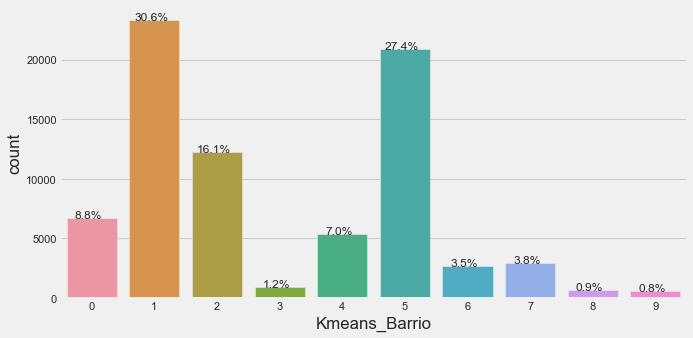

In [85]:
plt.figure(figsize=(10,5))
ax=sns.countplot(data = data, x = 'Kmeans_Barrio')
without_hue(ax,data.Kmeans_Barrio)

In [86]:
data = pd.get_dummies(data, columns = ['Kmeans_Barrio'])
data.head()

,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type_Casa,property_type_Departamento,property_type_PH,...,Kmeans_Barrio_0,Kmeans_Barrio_1,Kmeans_Barrio_2,Kmeans_Barrio_3,Kmeans_Barrio_4,Kmeans_Barrio_5,Kmeans_Barrio_6,Kmeans_Barrio_7,Kmeans_Barrio_8,Kmeans_Barrio_9
1,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
2,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
3,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
5,Villa Crespo,2.0,1.0,1.0,56.0,56.0,150000.0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
6,Villa Crespo,2.0,1.0,1.0,70.0,70.0,159500.0,0,0,1,...,0,0,0,0,0,1,0,0,0,0


## Missing values

Empezamos mirando los valores faltantes por columnna

In [87]:
data.isnull().sum()

l3                              0
rooms                           0
bedrooms                        0
bathrooms                     825
surface_total                   0
surface_covered               490
price                           0
property_type_Casa              0
property_type_Departamento      0
property_type_PH                0
valor_m2_miles                490
valorMedio_M2_Barrio            0
Kmeans_Barrio_0                 0
Kmeans_Barrio_1                 0
Kmeans_Barrio_2                 0
Kmeans_Barrio_3                 0
Kmeans_Barrio_4                 0
Kmeans_Barrio_5                 0
Kmeans_Barrio_6                 0
Kmeans_Barrio_7                 0
Kmeans_Barrio_8                 0
Kmeans_Barrio_9                 0
dtype: int64

No hay demasiados valores faltantes a raíz del preprocesamiento realizado hasta ahora. Cuando diseñé esta parte, la cantidad era bastante mayor. De todos modos, mantengo la metodología, para dar muestras del trabajo realizado. 

La estratégia es imputar datos faltantes con la media (superficie)/mediana (baños) de valores agrupados, surgidos de clusterización con DBSCAN (intento tener el menor noise posible, controlando el epsilon y un min_samples bajo), usando un slice con variables numéricas que no tengan NaN. Uso 'rooms' y 'bedrooms', las de propiedad transformadas, y también 'price'.

### Imputación con DBSCAN

In [88]:
data.columns

Index(['l3', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered', 'price', 'property_type_Casa',
       'property_type_Departamento', 'property_type_PH', 'valor_m2_miles',
       'valorMedio_M2_Barrio', 'Kmeans_Barrio_0', 'Kmeans_Barrio_1',
       'Kmeans_Barrio_2', 'Kmeans_Barrio_3', 'Kmeans_Barrio_4',
       'Kmeans_Barrio_5', 'Kmeans_Barrio_6', 'Kmeans_Barrio_7',
       'Kmeans_Barrio_8', 'Kmeans_Barrio_9'],
      dtype='object')

In [89]:
# Hago el slice
X_1 = data.drop(columns=['l3', 'surface_covered','bathrooms', 'valor_m2_miles', 'valorMedio_M2_Barrio', 
                         'Kmeans_Barrio_0', 'Kmeans_Barrio_1','Kmeans_Barrio_2', 'Kmeans_Barrio_3', 
                         'Kmeans_Barrio_4','Kmeans_Barrio_5', 'Kmeans_Barrio_6', 'Kmeans_Barrio_7',
                         'Kmeans_Barrio_8', 'Kmeans_Barrio_9'])

In [90]:
X_1.shape

(76227, 7)

In [91]:
# Instancio el modelo. Después puedo ajustar hiperparámetros
db_2 = DBSCAN(eps=1.5, min_samples=2, algorithm= 'auto', n_jobs=-1)

In [92]:
# Entreno el modelo
db_2.fit(X_1)

DBSCAN(algorithm='auto', eps=1.5, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=2, n_jobs=-1, p=None)

In [93]:
# Consultamos las etiquetas
labels_2 = db_2.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_2 = len(set(labels_2)) - (1 if -1 in labels_2 else 0)
n_noise_2 = list(labels_2).count(-1)

In [94]:
print('Estimated number of clusters: %d' % n_clusters_2)
print('Estimated number of noise points: %d' % n_noise_2)

Estimated number of clusters: 6565
Estimated number of noise points: 8063


In [95]:
# Inserto nueva columna en data con los valores de clusters
data['clusters_DBSCAN']=db_2.labels_
data.head()

,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type_Casa,property_type_Departamento,property_type_PH,...,Kmeans_Barrio_1,Kmeans_Barrio_2,Kmeans_Barrio_3,Kmeans_Barrio_4,Kmeans_Barrio_5,Kmeans_Barrio_6,Kmeans_Barrio_7,Kmeans_Barrio_8,Kmeans_Barrio_9,clusters_DBSCAN
1,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
2,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
3,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,0,0,1,...,1,0,0,0,0,0,0,0,0,-1
5,Villa Crespo,2.0,1.0,1.0,56.0,56.0,150000.0,0,0,1,...,0,0,0,0,1,0,0,0,0,2
6,Villa Crespo,2.0,1.0,1.0,70.0,70.0,159500.0,0,0,1,...,0,0,0,0,1,0,0,0,0,3


HICIMOS EL DBSCAN. OBTUVIMOS 12255 CLUSTERS. **AHORA NECESITAMOS QUE A LA CELDA VACIA SE LE IMPUTE LA MODA QUE TIENE ESE ATRIBUTO EN ESE CLUSTER.**

(0, 400)

<Figure size 1728x432 with 0 Axes>

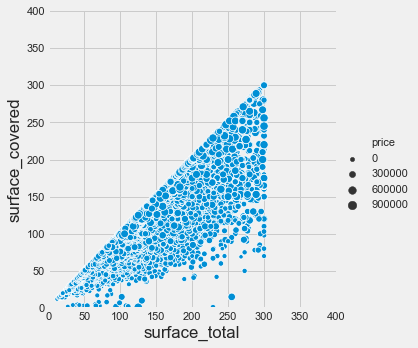

In [96]:
plt.figure(figsize = (12*2,6))
ax = sns.relplot(x="surface_total", y="surface_covered", size='price',data=data, palette="ch:r=-.5,l=.75")
plt.xlim (0,400)
plt.ylim (0,400)

In [97]:
data['surface_covered'].fillna(data.groupby(['clusters_DBSCAN'])['surface_covered'].transform('mean'), inplace=True)

In [98]:
# Comprobamos los NaN restantes
data.isnull().sum()

l3                              0
rooms                           0
bedrooms                        0
bathrooms                     825
surface_total                   0
surface_covered                29
price                           0
property_type_Casa              0
property_type_Departamento      0
property_type_PH                0
valor_m2_miles                490
valorMedio_M2_Barrio            0
Kmeans_Barrio_0                 0
Kmeans_Barrio_1                 0
Kmeans_Barrio_2                 0
Kmeans_Barrio_3                 0
Kmeans_Barrio_4                 0
Kmeans_Barrio_5                 0
Kmeans_Barrio_6                 0
Kmeans_Barrio_7                 0
Kmeans_Barrio_8                 0
Kmeans_Barrio_9                 0
clusters_DBSCAN                 0
dtype: int64

(0, 400)

<Figure size 1728x432 with 0 Axes>

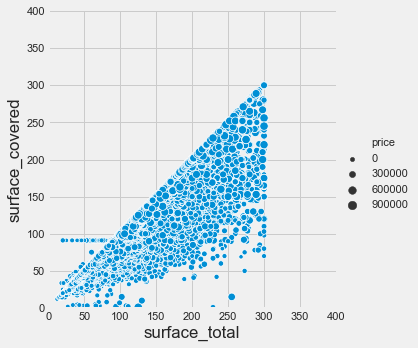

In [99]:
plt.figure(figsize = (12*2,6))
ax = sns.relplot(x="surface_total", y="surface_covered", size='price', data=data, palette="ch:r=-.5,l=.75")
plt.xlim (0,400)
plt.ylim (0,400)

Tengo que eliminar las imputaciones de sup.cov>sup.total

In [100]:
i_sup_imp = data[((data.surface_total < data.surface_covered))].index

In [101]:
data.drop((i_sup_imp), inplace=True)

(0, 400)

<Figure size 1728x432 with 0 Axes>

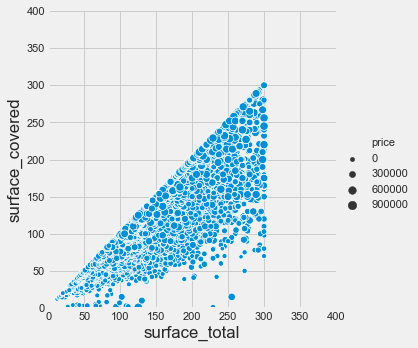

In [102]:
plt.figure(figsize = (12*2,6))
ax = sns.relplot(x="surface_total", y="surface_covered", size='price', data=data, palette="ch:r=-.5,l=.75")
plt.xlim (0,400)
plt.ylim (0,400)

Vamos a repetir para bathrooms

In [103]:
data['bathrooms'].fillna(data.groupby(['clusters_DBSCAN'])['bathrooms'].transform('median'), inplace=True)

In [104]:
data.isnull().sum()

l3                              0
rooms                           0
bedrooms                        0
bathrooms                      67
surface_total                   0
surface_covered                29
price                           0
property_type_Casa              0
property_type_Departamento      0
property_type_PH                0
valor_m2_miles                385
valorMedio_M2_Barrio            0
Kmeans_Barrio_0                 0
Kmeans_Barrio_1                 0
Kmeans_Barrio_2                 0
Kmeans_Barrio_3                 0
Kmeans_Barrio_4                 0
Kmeans_Barrio_5                 0
Kmeans_Barrio_6                 0
Kmeans_Barrio_7                 0
Kmeans_Barrio_8                 0
Kmeans_Barrio_9                 0
clusters_DBSCAN                 0
dtype: int64

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

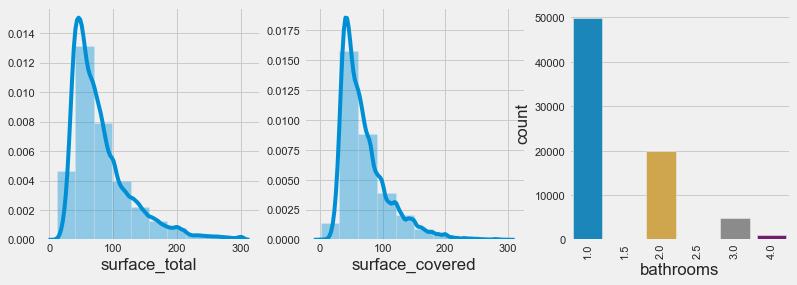

In [105]:
#mask_fillna = data [(data['surface_total']<= 400) & (data['surface_covered']<=300)]

plt.figure(figsize=(3*4,4))
plt.subplot(1,3,1)
sns.distplot(data['surface_total'], bins = 10)

plt.subplot(1,3,2)
sns.distplot(data['surface_covered'], bins = 10)

plt.subplot(1,3,3)
sns.countplot (data = data, x = 'bathrooms')
plt.xticks(rotation = 90)

Compruebo que el método usado no alteró la distribución de los atributos, pero tengo baños con 1.5 y 2.5

In [106]:
mask_bath = data [(data['bathrooms']== 1.5) | (data['bathrooms']== 2.5)]
mask_bath

,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type_Casa,property_type_Departamento,property_type_PH,...,Kmeans_Barrio_1,Kmeans_Barrio_2,Kmeans_Barrio_3,Kmeans_Barrio_4,Kmeans_Barrio_5,Kmeans_Barrio_6,Kmeans_Barrio_7,Kmeans_Barrio_8,Kmeans_Barrio_9,clusters_DBSCAN
6167,Belgrano,4.0,3.0,1.5,116.0,107.5,430000.0,0,1,0,...,1,0,0,0,0,0,0,0,0,1242
18626,Belgrano,4.0,3.0,1.5,158.0,150.0,415000.0,0,1,0,...,1,0,0,0,0,0,0,0,0,2569
19192,Villa Crespo,3.0,2.0,1.5,85.0,73.0,299000.0,0,1,0,...,0,0,0,0,1,0,0,0,0,2259
20012,Puerto Madero,3.0,2.0,2.5,145.0,111.0,650000.0,0,1,0,...,0,0,1,0,0,0,0,0,0,720
20409,Villa Devoto,3.0,2.0,1.5,135.0,77.0,315000.0,0,1,0,...,0,0,0,0,1,0,0,0,0,1760
44989,Villa Devoto,3.0,2.0,1.5,135.0,77.0,315000.0,0,1,0,...,0,0,0,0,1,0,0,0,0,1760
76397,Palermo,4.0,3.0,1.5,95.0,95.0,249000.0,0,1,0,...,1,0,0,0,0,0,0,0,0,2967
78178,Villa Crespo,3.0,2.0,1.5,85.0,73.0,299000.0,0,1,0,...,0,0,0,0,1,0,0,0,0,2259
78644,San Nicolás,5.0,4.0,1.5,110.0,95.0,239000.0,0,1,0,...,0,0,0,0,1,0,0,0,0,2220
79099,Villa Luro,4.0,3.0,2.5,180.0,150.0,450000.0,0,1,0,...,0,1,0,0,0,0,0,0,0,5596


In [107]:
i7 = data [(data['bathrooms']== 1.5) | (data['bathrooms']== 2.5)].index

In [108]:
data.drop((i7), inplace=True)

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

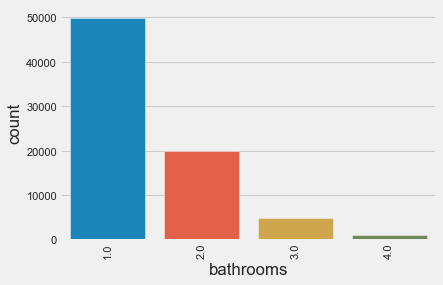

In [109]:
sns.countplot (data = data, x = 'bathrooms')
plt.xticks(rotation = 90)

### Eliminación de datos faltantes

Vamos a quitar las pocas instancias Nan que nos quedaron

In [110]:
data.columns

Index(['l3', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered', 'price', 'property_type_Casa',
       'property_type_Departamento', 'property_type_PH', 'valor_m2_miles',
       'valorMedio_M2_Barrio', 'Kmeans_Barrio_0', 'Kmeans_Barrio_1',
       'Kmeans_Barrio_2', 'Kmeans_Barrio_3', 'Kmeans_Barrio_4',
       'Kmeans_Barrio_5', 'Kmeans_Barrio_6', 'Kmeans_Barrio_7',
       'Kmeans_Barrio_8', 'Kmeans_Barrio_9', 'clusters_DBSCAN'],
      dtype='object')

In [111]:
data.drop(columns=['valor_m2_miles', 'valorMedio_M2_Barrio'], inplace=True)

In [112]:
data.dropna(inplace=True)

In [113]:
data.head()

,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type_Casa,property_type_Departamento,property_type_PH,...,Kmeans_Barrio_1,Kmeans_Barrio_2,Kmeans_Barrio_3,Kmeans_Barrio_4,Kmeans_Barrio_5,Kmeans_Barrio_6,Kmeans_Barrio_7,Kmeans_Barrio_8,Kmeans_Barrio_9,clusters_DBSCAN
1,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
2,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
3,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,0,0,1,...,1,0,0,0,0,0,0,0,0,-1
5,Villa Crespo,2.0,1.0,1.0,56.0,56.0,150000.0,0,0,1,...,0,0,0,0,1,0,0,0,0,2
6,Villa Crespo,2.0,1.0,1.0,70.0,70.0,159500.0,0,0,1,...,0,0,0,0,1,0,0,0,0,3


## Outliers

Las estratégias de rango intercuartílico y de tres sigmas no funcionan bien cuando las distribuciones subyacentes no son normales. 

Ya realicé un depurado manual, quitando las colas de las distribuciones. Acá voy con otra estratégia, pensando en dejar un dataset lo más magro y preciso posible. Voy a realizar Isolation Forest con un contamination bajo, y un DBSCAN, y luego removeré las instancias que sean clasificadas como outliers por ambos modelos.

In [114]:
data.shape

(76017, 21)

In [115]:
data.columns

Index(['l3', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered', 'price', 'property_type_Casa',
       'property_type_Departamento', 'property_type_PH', 'Kmeans_Barrio_0',
       'Kmeans_Barrio_1', 'Kmeans_Barrio_2', 'Kmeans_Barrio_3',
       'Kmeans_Barrio_4', 'Kmeans_Barrio_5', 'Kmeans_Barrio_6',
       'Kmeans_Barrio_7', 'Kmeans_Barrio_8', 'Kmeans_Barrio_9',
       'clusters_DBSCAN'],
      dtype='object')

In [116]:
# Creamos la matriz de features
X_IF_SUP = data.drop(['l3', 'property_type_Casa',
       'property_type_Departamento', 'property_type_PH', 'Kmeans_Barrio_0',
       'Kmeans_Barrio_1', 'Kmeans_Barrio_2', 'Kmeans_Barrio_3',
       'Kmeans_Barrio_4', 'Kmeans_Barrio_5', 'Kmeans_Barrio_6',
       'Kmeans_Barrio_7', 'Kmeans_Barrio_8', 'Kmeans_Barrio_9',
       'clusters_DBSCAN'], axis=1)

X_IF_SUP

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
1,2.0,1.0,2.0,70.0,58.0,159000.0
2,2.0,1.0,1.0,45.0,45.0,125000.0
3,2.0,1.0,1.0,85.0,50.0,295000.0
5,2.0,1.0,1.0,56.0,56.0,150000.0
6,2.0,1.0,1.0,70.0,70.0,159500.0
...,...,...,...,...,...,...
146552,4.0,2.0,3.0,159.0,98.0,539000.0
146553,4.0,3.0,2.0,106.0,100.0,620000.0
146554,4.0,3.0,3.0,175.0,111.0,570000.0
146555,3.0,2.0,2.0,144.0,134.0,480000.0


### Isolation Forest

In [117]:
from sklearn.ensemble import IsolationForest

In [118]:
model_IF=IsolationForest(n_estimators=500, max_samples='auto', contamination= 0.01, max_features=.8, n_jobs=-1, 
                         random_state=42)
model_IF.fit(X_IF_SUP)

IsolationForest(behaviour='deprecated', bootstrap=False, contamination=0.01,
                max_features=0.8, max_samples='auto', n_estimators=500,
                n_jobs=-1, random_state=42, verbose=0, warm_start=False)

In [119]:
data['outliers']=model_IF.predict(X_IF_SUP)
data.head()

,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type_Casa,property_type_Departamento,property_type_PH,...,Kmeans_Barrio_2,Kmeans_Barrio_3,Kmeans_Barrio_4,Kmeans_Barrio_5,Kmeans_Barrio_6,Kmeans_Barrio_7,Kmeans_Barrio_8,Kmeans_Barrio_9,clusters_DBSCAN,outliers
1,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
2,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,0,0,1,...,0,0,0,0,0,0,0,0,1,1
3,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,0,0,1,...,0,0,0,0,0,0,0,0,-1,1
5,Villa Crespo,2.0,1.0,1.0,56.0,56.0,150000.0,0,0,1,...,0,0,0,1,0,0,0,0,2,1
6,Villa Crespo,2.0,1.0,1.0,70.0,70.0,159500.0,0,0,1,...,0,0,0,1,0,0,0,0,3,1


In [120]:
mask_outliers = data[(data['outliers']== -1)]

In [121]:
mask_outliers.shape

(749, 22)

<function matplotlib.pyplot.show(*args, **kw)>

<Figure size 1728x432 with 0 Axes>

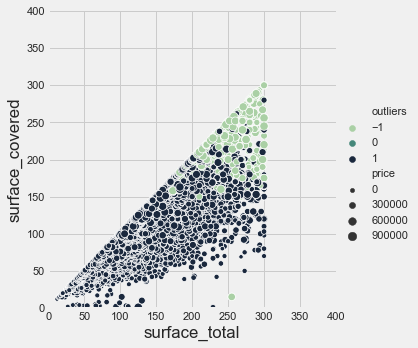

In [122]:
plt.figure(figsize = (12*2,6))
ax = sns.relplot(x="surface_total", y="surface_covered", size='price', hue="outliers", data=data, palette="ch:r=-.5,l=.75")
plt.xlim (0,400)
plt.ylim (0,400)

plt.show

In [123]:
mask_outliers.head(20)

,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type_Casa,property_type_Departamento,property_type_PH,...,Kmeans_Barrio_2,Kmeans_Barrio_3,Kmeans_Barrio_4,Kmeans_Barrio_5,Kmeans_Barrio_6,Kmeans_Barrio_7,Kmeans_Barrio_8,Kmeans_Barrio_9,clusters_DBSCAN,outliers
293,Recoleta,6.0,3.0,3.0,218.0,218.0,740000.0,0,1,0,...,0,0,0,0,0,0,0,0,-1,-1
295,Recoleta,5.0,3.0,4.0,202.0,202.0,640000.0,0,1,0,...,0,0,0,0,0,0,0,0,127,-1
320,Nuñez,4.0,4.0,3.0,231.0,209.0,690000.0,0,1,0,...,0,0,0,0,0,0,0,0,139,-1
328,Belgrano,4.0,4.0,3.0,231.0,209.0,690000.0,0,1,0,...,0,0,0,0,0,0,0,0,139,-1
329,Belgrano,4.0,4.0,3.0,231.0,209.0,690000.0,0,1,0,...,0,0,0,0,0,0,0,0,139,-1
331,Recoleta,6.0,4.0,3.0,264.0,264.0,750000.0,0,1,0,...,0,0,0,0,0,0,0,0,142,-1
332,Las Cañitas,4.0,4.0,3.0,231.0,209.0,690000.0,0,1,0,...,0,0,0,0,0,0,0,1,139,-1
441,Paternal,5.0,4.0,1.0,280.0,280.0,285000.0,0,0,1,...,1,0,0,0,0,0,0,0,192,-1
1085,Belgrano,5.0,4.0,3.0,277.0,240.0,590000.0,0,1,0,...,0,0,0,0,0,0,0,0,342,-1
1086,Belgrano,5.0,3.0,4.0,214.0,170.0,690000.0,0,1,0,...,0,0,0,0,0,0,0,0,-1,-1


Voy a hacer un DBSCAN, entonces, voy a sacar los valores que ambos modelos clasifiquen como outliers

### DBSCAN

In [124]:
db_out = DBSCAN(eps=.6, min_samples=5, algorithm= 'auto', n_jobs=-1)
db_out.fit(X_IF_SUP)

DBSCAN(algorithm='auto', eps=0.6, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=-1, p=None)

In [125]:
data['outliers_DBSCAN']=db_out.labels_
data.head()

,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type_Casa,property_type_Departamento,property_type_PH,...,Kmeans_Barrio_3,Kmeans_Barrio_4,Kmeans_Barrio_5,Kmeans_Barrio_6,Kmeans_Barrio_7,Kmeans_Barrio_8,Kmeans_Barrio_9,clusters_DBSCAN,outliers,outliers_DBSCAN
1,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,0,0,1,...,0,0,0,0,0,0,0,0,1,-1
2,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,0,0,1,...,0,0,0,0,0,0,0,1,1,0
3,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,0,0,1,...,0,0,0,0,0,0,0,-1,1,-1
5,Villa Crespo,2.0,1.0,1.0,56.0,56.0,150000.0,0,0,1,...,0,0,1,0,0,0,0,2,1,-1
6,Villa Crespo,2.0,1.0,1.0,70.0,70.0,159500.0,0,0,1,...,0,0,1,0,0,0,0,3,1,1


### Outliers conjuntos

In [126]:
mask_outliers_2 = data[(data['outliers']== -1) & (data['outliers_DBSCAN']== -1)]
mask_outliers_2.shape

(600, 23)

<function matplotlib.pyplot.show(*args, **kw)>

<Figure size 1728x432 with 0 Axes>

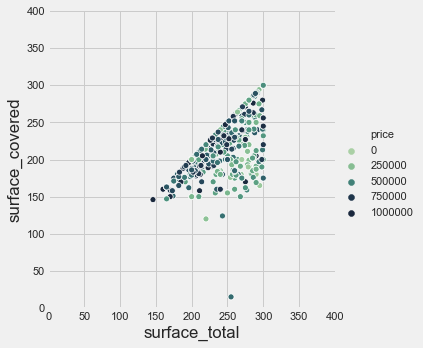

In [127]:
plt.figure(figsize = (12*2,6))
ax = sns.relplot(x="surface_total", y="surface_covered", hue='price', data=mask_outliers_2, palette="ch:r=-.5,l=.75")
plt.xlim (0,400)
plt.ylim (0,400)

plt.show

In [128]:
mask_outliers_2.head(20)

,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type_Casa,property_type_Departamento,property_type_PH,...,Kmeans_Barrio_3,Kmeans_Barrio_4,Kmeans_Barrio_5,Kmeans_Barrio_6,Kmeans_Barrio_7,Kmeans_Barrio_8,Kmeans_Barrio_9,clusters_DBSCAN,outliers,outliers_DBSCAN
293,Recoleta,6.0,3.0,3.0,218.0,218.0,740000.0,0,1,0,...,0,0,0,0,0,0,0,-1,-1,-1
295,Recoleta,5.0,3.0,4.0,202.0,202.0,640000.0,0,1,0,...,0,0,0,0,0,0,0,127,-1,-1
331,Recoleta,6.0,4.0,3.0,264.0,264.0,750000.0,0,1,0,...,0,0,0,0,0,0,0,142,-1,-1
1085,Belgrano,5.0,4.0,3.0,277.0,240.0,590000.0,0,1,0,...,0,0,0,0,0,0,0,342,-1,-1
1086,Belgrano,5.0,3.0,4.0,214.0,170.0,690000.0,0,1,0,...,0,0,0,0,0,0,0,-1,-1,-1
1088,Recoleta,5.0,4.0,3.0,212.0,205.0,650000.0,0,1,0,...,0,0,0,0,0,0,0,343,-1,-1
1573,Villa del Parque,6.0,4.0,3.0,260.0,160.0,370000.0,1,0,0,...,0,0,1,0,0,0,0,-1,-1,-1
1879,Mataderos,5.0,3.0,3.0,270.0,270.0,280000.0,1,0,0,...,0,0,0,1,0,0,0,-1,-1,-1
1959,Belgrano,5.0,4.0,1.0,249.0,249.0,500000.0,1,0,0,...,0,0,0,0,0,0,0,-1,-1,-1
2667,Puerto Madero,4.0,2.0,4.0,205.0,185.0,672000.0,0,1,0,...,1,0,0,0,0,0,0,661,-1,-1


In [129]:
i8 = data[(data['outliers']== -1) & (data['outliers_DBSCAN']== -1)].index

In [130]:
data.drop((i8), inplace=True)

In [131]:
data.shape

(75417, 23)

In [132]:
data.describe().round(2)

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type_Casa,property_type_Departamento,property_type_PH,Kmeans_Barrio_0,...,Kmeans_Barrio_3,Kmeans_Barrio_4,Kmeans_Barrio_5,Kmeans_Barrio_6,Kmeans_Barrio_7,Kmeans_Barrio_8,Kmeans_Barrio_9,clusters_DBSCAN,outliers,outliers_DBSCAN
count,75417.00,75417.00,75417.00,75417.00,75417.00,75417.00,75417.00,75417.00,75417.00,75417.00,...,75417.00,75417.00,75417.00,75417.00,75417.00,75417.00,75417.00,75417.00,75417.00,75417.00
mean,2.82,1.86,1.42,79.91,69.61,207556.15,0.01,0.87,0.12,0.09,...,0.01,0.07,0.28,0.03,0.04,0.01,0.01,1111.54,1.00,309.48
std,1.04,0.87,0.66,44.52,35.82,126578.73,0.12,0.34,0.32,0.28,...,0.11,0.26,0.45,0.18,0.19,0.09,0.09,1627.33,0.09,565.89
min,1.00,0.00,1.00,12.00,1.00,10800.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.00,-1.00,-1.00
25%,2.00,1.00,1.00,48.00,43.00,120000.00,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,35.00,1.00,-1.00
50%,3.00,2.00,1.00,67.00,60.00,170000.00,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,272.00,1.00,-1.00
75%,4.00,2.00,2.00,99.00,85.00,255000.00,0.00,1.00,0.00,0.00,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1581.00,1.00,384.00
max,6.00,4.00,4.00,300.00,300.00,800000.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,6564.00,1.00,2242.00


## Escalado de datos

Salvo por árboles de decisión, los modelos de ML dependen básicamente de variables numéricas. Y estas deben estar en escalas comparables, ya que los modelos no entienden de unidades. Repasemos las distribuciones, para luego optar por el tipo adecuado de escalado.

Text(0, 0.5, 'Cantidad de propiedades')

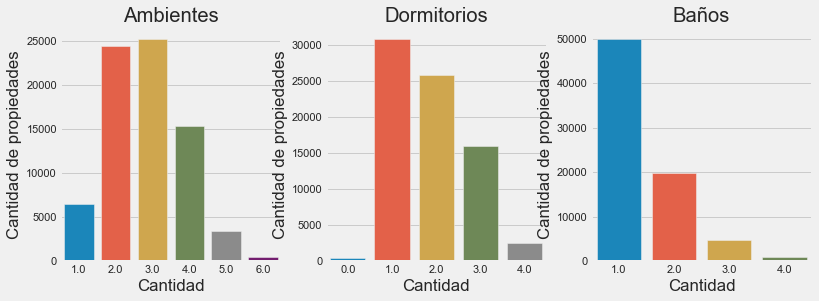

In [133]:
plt.figure(figsize = (4*3,4))

plt.subplot(1,3,1)
sns.countplot(data = data, x = 'rooms')
plt.title('Ambientes')
plt.xlabel('Cantidad')
plt.ylabel('Cantidad de propiedades')

plt.subplot(1,3,2)
sns.countplot(data = data, x = 'bedrooms')
plt.title('Dormitorios')
plt.xlabel('Cantidad')
plt.ylabel('Cantidad de propiedades')

plt.subplot(1,3,3)
sns.countplot(data = data, x = 'bathrooms')
plt.title('Baños')
plt.xlabel('Cantidad')
plt.ylabel('Cantidad de propiedades')

Ahora voy a mirar las distribuciones de superficies

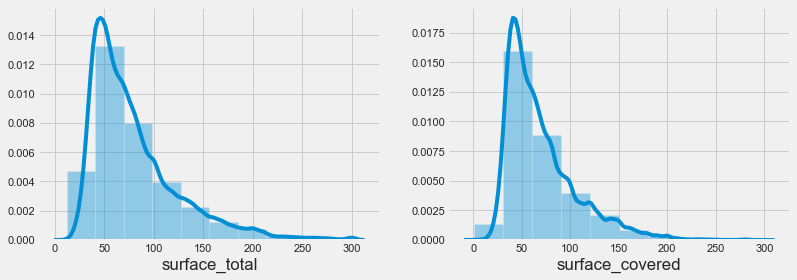

In [134]:
plt.figure(figsize=(3*4,4))

plt.subplot(1,2,1)
sns.distplot(data['surface_total'], bins = 10)

plt.subplot(1,2,2)
sns.distplot(data['surface_covered'], bins = 10)

Quiero ver como quedaron representados los barrios

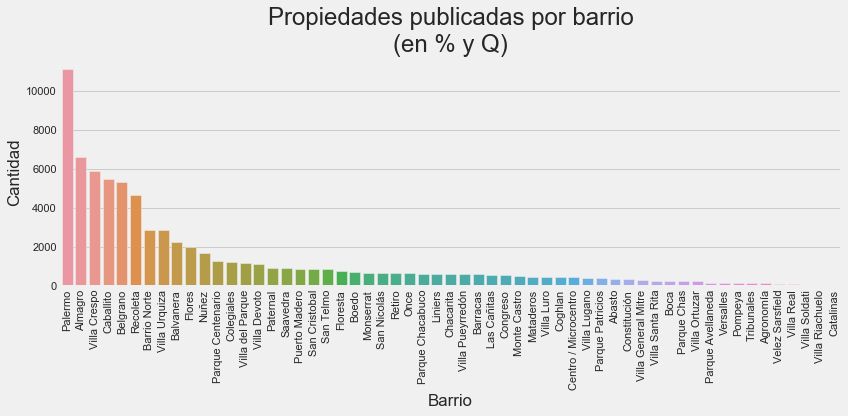

In [135]:
plt.figure(figsize = (12,6))
ax = sns.countplot(data = data, x = 'l3', order = data['l3'].value_counts().index)
plt.xticks(rotation = 90)
plt.title('Propiedades publicadas por barrio\n(en % y Q)', fontsize = 24)

plt.ylabel('Cantidad')
plt.xlabel('Barrio')
plt.tight_layout()
#without_hue (ax, data.l3)
#plt.savefig('Cantidad de propiedades (por barrio).png', bbox_inches='tight', dpi = 400)
plt.show()

### MinMaxScaler

Veo que las distribuciones no son normales (salvo por ambientes, que se asemeja mucho). Opto por realizar un MinMaxScaler. Recordemos que el escalado es para unificar la ponderación de los valores de los atributos, de modo que los modelos (fundamentalmente los apoyados en distancias), no confundan unidades de medida con importancia. El MinMaxScaler no cambia la distribución de origen de los datos.

In [136]:
data.columns

Index(['l3', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered', 'price', 'property_type_Casa',
       'property_type_Departamento', 'property_type_PH', 'Kmeans_Barrio_0',
       'Kmeans_Barrio_1', 'Kmeans_Barrio_2', 'Kmeans_Barrio_3',
       'Kmeans_Barrio_4', 'Kmeans_Barrio_5', 'Kmeans_Barrio_6',
       'Kmeans_Barrio_7', 'Kmeans_Barrio_8', 'Kmeans_Barrio_9',
       'clusters_DBSCAN', 'outliers', 'outliers_DBSCAN'],
      dtype='object')

In [137]:
data.drop(['clusters_DBSCAN', 'outliers', 'outliers_DBSCAN'], axis=1, inplace=True)

In [138]:
from sklearn.preprocessing import MinMaxScaler

In [139]:
data.columns

Index(['l3', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered', 'price', 'property_type_Casa',
       'property_type_Departamento', 'property_type_PH', 'Kmeans_Barrio_0',
       'Kmeans_Barrio_1', 'Kmeans_Barrio_2', 'Kmeans_Barrio_3',
       'Kmeans_Barrio_4', 'Kmeans_Barrio_5', 'Kmeans_Barrio_6',
       'Kmeans_Barrio_7', 'Kmeans_Barrio_8', 'Kmeans_Barrio_9'],
      dtype='object')

In [140]:
scaler = MinMaxScaler()

In [141]:
data[['rooms']] = scaler.fit_transform(data[['rooms']])
data[['bedrooms']] = scaler.fit_transform(data[['bedrooms']])
data[['bathrooms']] = scaler.fit_transform(data[['bathrooms']])
data[['surface_total']] = scaler.fit_transform(data[['surface_total']])
data[['surface_covered']] = scaler.fit_transform(data[['surface_covered']])

In [142]:
data.head()

,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type_Casa,property_type_Departamento,property_type_PH,Kmeans_Barrio_0,Kmeans_Barrio_1,Kmeans_Barrio_2,Kmeans_Barrio_3,Kmeans_Barrio_4,Kmeans_Barrio_5,Kmeans_Barrio_6,Kmeans_Barrio_7,Kmeans_Barrio_8,Kmeans_Barrio_9
1,Boedo,0.2,0.25,0.333333,0.201389,0.190635,159000.0,0,0,1,0,0,1,0,0,0,0,0,0,0
2,Palermo,0.2,0.25,0.000000,0.114583,0.147157,125000.0,0,0,1,0,1,0,0,0,0,0,0,0,0
3,Palermo,0.2,0.25,0.000000,0.253472,0.163880,295000.0,0,0,1,0,1,0,0,0,0,0,0,0,0
5,Villa Crespo,0.2,0.25,0.000000,0.152778,0.183946,150000.0,0,0,1,0,0,0,0,0,1,0,0,0,0
6,Villa Crespo,0.2,0.25,0.000000,0.201389,0.230769,159500.0,0,0,1,0,0,0,0,0,1,0,0,0,0


In [143]:
data.shape

(75417, 20)

## Nuevas variables/reducción de dimensionalidad

In [144]:
X = data.drop(['l3', 'price'], axis=1)

In [145]:
X.head()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,property_type_Casa,property_type_Departamento,property_type_PH,Kmeans_Barrio_0,Kmeans_Barrio_1,Kmeans_Barrio_2,Kmeans_Barrio_3,Kmeans_Barrio_4,Kmeans_Barrio_5,Kmeans_Barrio_6,Kmeans_Barrio_7,Kmeans_Barrio_8,Kmeans_Barrio_9
1,0.2,0.25,0.333333,0.201389,0.190635,0,0,1,0,0,1,0,0,0,0,0,0,0
2,0.2,0.25,0.000000,0.114583,0.147157,0,0,1,0,1,0,0,0,0,0,0,0,0
3,0.2,0.25,0.000000,0.253472,0.163880,0,0,1,0,1,0,0,0,0,0,0,0,0
5,0.2,0.25,0.000000,0.152778,0.183946,0,0,1,0,0,0,0,0,1,0,0,0,0
6,0.2,0.25,0.000000,0.201389,0.230769,0,0,1,0,0,0,0,0,1,0,0,0,0


In [146]:
from sklearn.decomposition import PCA

pca = PCA(n_components=8)
X_nuevo = pca.fit_transform(X) 

In [147]:
data.reset_index(inplace=True)

In [148]:
y = data[['price']]

In [149]:
X_nuevo = pd.DataFrame (X_nuevo)

In [150]:
X_nuevo[['price']] = data[['price']]

In [151]:
X_nuevo.head()

,0,1,2,3,4,5,6,7,price
0,0.448474,1.289700,-0.322523,-0.571951,-0.193688,-0.089856,-0.060738,-0.129644,159000.0
1,-0.352926,0.912468,0.649504,-0.892030,0.215008,-0.081027,-0.001086,-0.124224,125000.0
2,-0.353765,0.934298,0.668121,-0.850152,0.200980,-0.075278,-0.002208,-0.119597,295000.0
3,0.992205,0.521288,0.675744,-0.727431,0.143058,-0.071986,-0.010656,-0.115647,150000.0
4,0.991440,0.533005,0.686161,-0.703170,0.134729,-0.068966,-0.011250,-0.113636,159500.0


In [152]:
corr_pca = X_nuevo.corr(method= 'spearman')

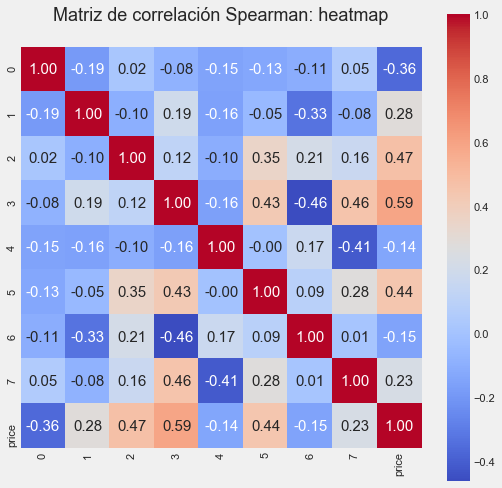

In [153]:
plt.figure(figsize=(8,8))
sns.heatmap(corr_pca, cbar = True, square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
#xticklabels= corr1.drop(['lat', 'lon'], axis=1).columns,
#yticklabels= corr1.drop(['lat', 'lon'], axis=1).columns,
cmap= 'coolwarm')
plt.title('Matriz de correlación Spearman: heatmap\n', fontsize = 18)
plt.xticks(rotation = 90)
#plt.savefig('Matriz de correlación: heatmap.png', dpi = 800)
plt.show()

## Nuevo Benchmark: reentrenar modelo de Proyecto_01 con dataset preprocesado del Proyecto_02

Voy a reentrenar el árbol de decisión, según se sugiere en la bitácora del Proyecto_02, con los mismos valores de hiperparámetros que surgieron de la optimización del modelo para el Proyecto_01. Este será nuestro nuevo Benchmark.

In [154]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate

In [155]:
X_pca = X_nuevo.drop(['price'], axis=1)
y = X_nuevo['price']

In [156]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(52791, 8) (22626, 8) (52791,) (22626,)


### El modelo

Uso el modelo sugerido por la bitácora: DecisionTreeRegressor. Los hiperparámetros y sus valores son los del Proyecto_01. **NO ESTÁ OPTIMIZADO, ES SÓLO BENCHMARK**

In [157]:
tree_regressor = DecisionTreeRegressor(max_depth=20, random_state=42)

In [158]:
tree_regressor.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=20,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [159]:
# FUNCIÓN PARA EVALUAR MODELOS DE REGRESIÓN

def evaluar_regresion(model, X_train, X_test, y_train, y_test):
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    ### CALCULAMOS EL ERROR
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    R2_train = r2_score(y_train, y_train_pred)
    R2_test = r2_score(y_test, y_test_pred)

    print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
    print(f'Raíz del error cuadrático medio en Test: {rmse_test}')
    print(f'Coeficiente de Determinación en Train: {R2_train}')
    print(f'Coeficiente de Determinación en Test: {R2_test}\n')

    ### GRAFICAMOS LOS RESULTADOS
    
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    sns.distplot(y_train - y_train_pred, bins = 20, label = 'train')
    sns.distplot(y_test - y_test_pred, bins = 20, label = 'test')
    plt.xlabel('errores')
    plt.legend()

    ax = plt.subplot(1,2,2)
    ax.scatter(y_test,y_test_pred, s =2)

    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]

    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')

    plt.tight_layout()
    plt.show()

Raíz del error cuadrático medio en Train: 25974.11708309157
Raíz del error cuadrático medio en Test: 48944.44318242847
Coeficiente de Determinación en Train: 0.9578466881158494
Coeficiente de Determinación en Test: 0.8508548903372507



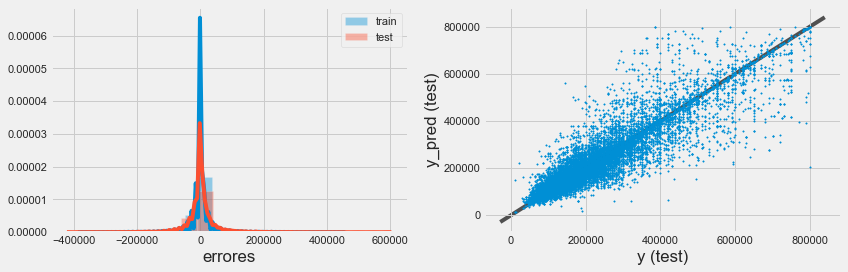

In [160]:
evaluar_regresion(tree_regressor, X_train, X_test, y_train, y_test)

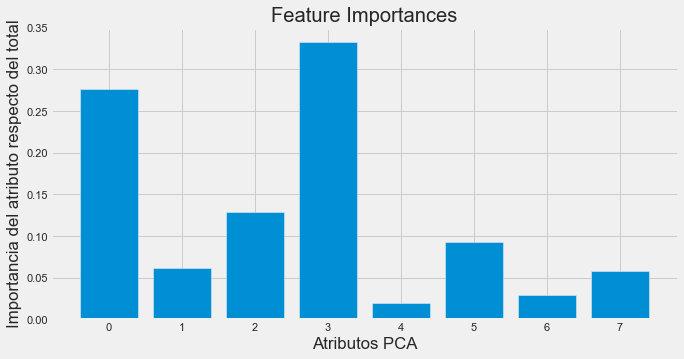

In [161]:
from matplotlib import pyplot

importance_tree_regressor = tree_regressor.feature_importances_
#plot feature importance
plt.figure(figsize = (10,5))
pyplot.bar([x for x in range(len(importance_tree_regressor))], importance_tree_regressor)
plt.title('Feature Importances')
plt.xlabel('Atributos PCA')
plt.ylabel('Importancia del atributo respecto del total')
pyplot.show()

### Benchmark comparado

**TreeRegressor comparado** 
* El RMSE en Train pasa de 55906 a 26294
* El RMSE en Test pasa de 150455 a 48481

La mejora es radical, sobre todo en el conjunto de Test, con el error reducido a un tercio.

Respuesta: finalmente, trabajamos con 75000 instancias, con modelo y valor de hiperparámatros invariables respecto del utilizado en Proyecto_01. La mejora se explica, hasta aquí, enteramente por el preprocesamiento. Acabamos con menos datos de entrada, pero luego de doble tratamiento de outliers, missing values casi nulos, con variables categóricas incorporadas al modelo, y atributos llevados a misma escala, luego reducidos a mejores expresiones de sí mediante PCA. Aclaro, al trabajar con árbol de decisión, el reescalado no nos explicaría mejora.

Vemos que tres variables (0, 2 y 3) reunen cerca del 80% del poder explicativo del modelo

# PARTE B y C: MODELOS AVANZADOS, justificación de hiperparámetros, y evaluación de resultados.

El objetivo es mejorar la performance lograda con el benchmark mediante el uso de modelos avanzados y la optimización manual de hiperparámetros o por medio de las técnicas aprendidas. También algo de intuición, por supuesto ;)

In [162]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso, LassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import scipy as sp

In [163]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.30, random_state=42)

## Regresión con atributos polinómicos y regularización Lasso, hiperparámetros por defecto.

Empiezo con un polinomial de grado 2, en una regresión lineal ajustada por Lasso, con alpha=1 y max_iter=1000. Elijo Lasso xq no tengo correlación entre variables independientes (producto del uso del PCA), y porque sospecho que varios regresores tendrán bajo o nulo impacto en explicar el precio.

In [164]:
poly = PolynomialFeatures()

In [165]:
X_train_new = poly.fit_transform(X_train)
X_test_new = poly.fit_transform(X_test)
print(X_train_new.shape,X_test_new.shape)

(52791, 45) (22626, 45)


In [166]:
reg_lasso = Lasso()
reg_lasso.fit(X_train_new,y_train)

print(f'Pendientes: {reg_lasso.coef_}')
print(f'Ordenada: {reg_lasso.intercept_}')


Pendientes: [       0.          -489709.65535838   150818.91053809   209683.89108099
   289469.40627699   721596.21482679  1215859.53089837   168756.7866214
   -57323.19922389   253123.12052128  -238627.22666065   188678.26873116
  -295492.39280109 -1254466.79630376 -4264028.74718701 -2608451.88040085
   440580.49342647   105937.34960709  -495090.82116105   133837.98124849
   151791.47672494   458518.33821471   607658.03925394  -311747.04734024
   375608.70009777   -64413.86418467   352760.07107332  1519298.28316838
    98797.14927319   357107.8358488     10400.54108509   -89566.93141744
  -741874.64261186    30949.58592081  -141945.17255938    13142.06091915
  -107458.44579862  1209512.5361622   -251350.85764214  -432243.3269161
   386455.60723364   615838.4280177   -483526.44654853   147942.19226856
  -360144.89254546]
Ordenada: 101810.22354226331


C:\Users\BagattinMarciano\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 126063110988580.72, tolerance: 84490868571.5006
  positive)


El nivel de alpha es muy pequeño, de modo que son pocos los atributos cuyos regresores son eliminados.

Raíz del error cuadrático medio en Train: 69708.55125397087
Raíz del error cuadrático medio en Test: 68700.1801056496
Coeficiente de Determinación en Train: 0.6963856963188586
Coeficiente de Determinación en Test: 0.706155216817707



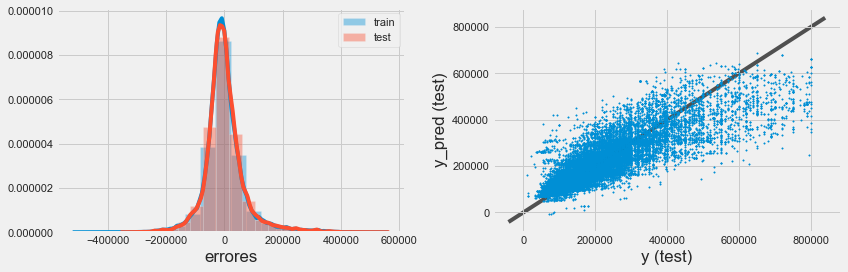

In [167]:
evaluar_regresion(reg_lasso, X_train_new, X_test_new, y_train, y_test)

La consistencia es casi perfecta, hay un error muy pequeño entre los sets de datos. Pero la precisión empeora bastante frente al benchark. Esta es una característica de los modelos de regresión lineal. Paradójicamente, esto implica complejizar el modelo para mejorar performance, a pesar de haberle agregado atributos polinómicos.

## Regresión con atributos polinómicos y regularización Lasso, hiperparámetros optimizados


Primero voy a mirar el grado óptimo para el polinomio, evaluado mediante RMSE (ya comprobé que los resultados sólo mejoran hasta degree=3, por eso voy a acortar el número de potencias, por el costo computacional).

REGRESIÓN CON ATRIBUTOS POLINÓMICOS NUMERO 1
Agregamos atributos hasta la potencia x**2
Raíz del error cuadrático medio en Train: 59006.190930979035
Raíz del error cuadrático medio en Test: 57990.69806960443
Coeficiente de Determinación en Train: 0.7824569192712083
Coeficiente de Determinación en Test: 0.7906278528333778



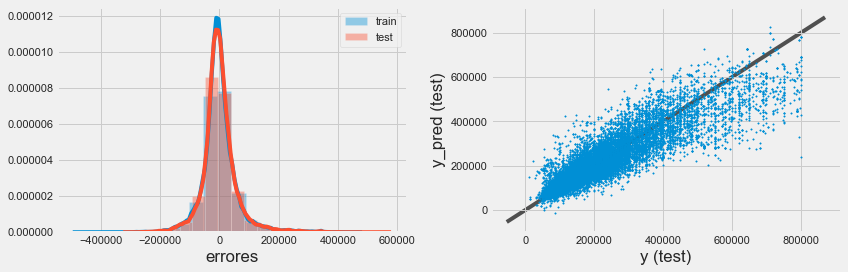

REGRESIÓN CON ATRIBUTOS POLINÓMICOS NUMERO 2
Agregamos atributos hasta la potencia x**3
Raíz del error cuadrático medio en Train: 53890.9572999533
Raíz del error cuadrático medio en Test: 53360.40154216459
Coeficiente de Determinación en Train: 0.81853958044189
Coeficiente de Determinación en Test: 0.8227278909524314



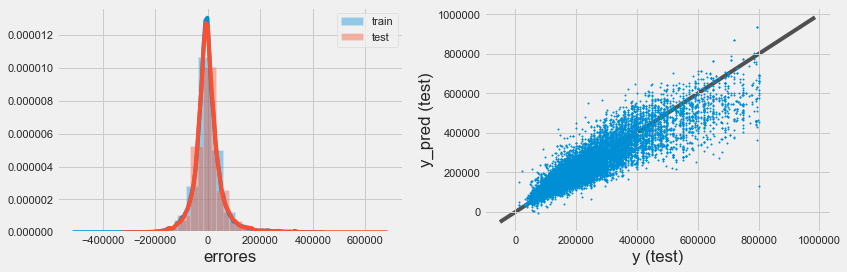

REGRESIÓN CON ATRIBUTOS POLINÓMICOS NUMERO 3
Agregamos atributos hasta la potencia x**4
Raíz del error cuadrático medio en Train: 52184.10744134807
Raíz del error cuadrático medio en Test: 82409.26530751096
Coeficiente de Determinación en Train: 0.82985208429277
Coeficiente de Determinación en Test: 0.577181171805424



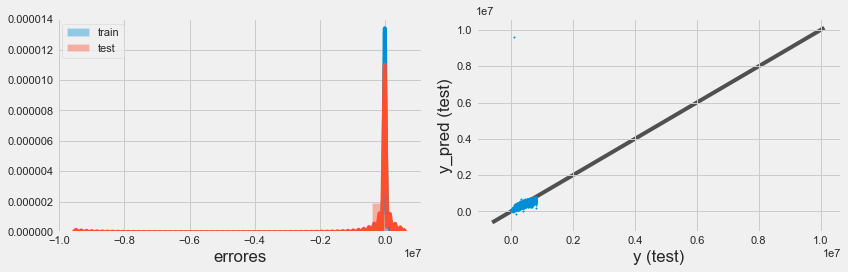

REGRESIÓN CON ATRIBUTOS POLINÓMICOS NUMERO 4
Agregamos atributos hasta la potencia x**5
Raíz del error cuadrático medio en Train: 50433.27543872318
Raíz del error cuadrático medio en Test: 7141352352367.354
Coeficiente de Determinación en Train: 0.841077838390345
Coeficiente de Determinación en Test: -3175142028993502.0



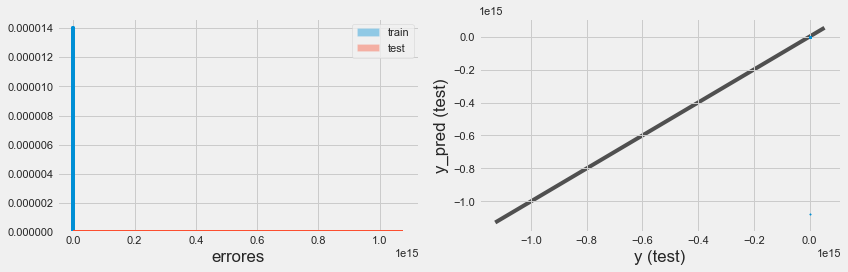

REGRESIÓN CON ATRIBUTOS POLINÓMICOS NUMERO 5
Agregamos atributos hasta la potencia x**6
Raíz del error cuadrático medio en Train: 48355.02138564486
Raíz del error cuadrático medio en Test: 22264938024934.41
Coeficiente de Determinación en Train: 0.853905699473324
Coeficiente de Determinación en Test: -3.0863502852929564e+16



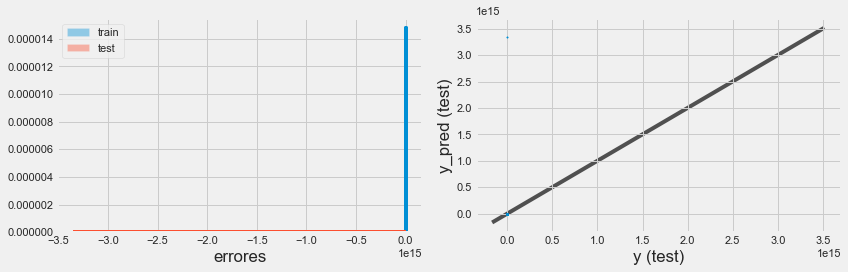

In [168]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.30, random_state=42)

for idx,potencia_maxima in enumerate(range(2,7)):
    print(f'REGRESIÓN CON ATRIBUTOS POLINÓMICOS NUMERO {idx + 1}')
    print(f'Agregamos atributos hasta la potencia x**{potencia_maxima}')
    
    
    for degree in range(2, potencia_maxima+1):
        X_train_new = PolynomialFeatures(degree= degree).fit_transform(X_train)
        X_test_new = PolynomialFeatures(degree= degree).fit_transform(X_test)

        
    
    ### ENTRENAMOS
    reg = LinearRegression()
    reg.fit(X_train_new, y_train)
    
    evaluar_regresion(reg, X_train_new, X_test_new, y_train, y_test)

Los mejores valores se presentan cuando llevamos los atributos hasta la 3ra potencia. Ahora tengo que construir la nueva 'X' con el modelo para esa potencia, para usarlo de input en GridSearch para el modelo de regularización. Voy a usar un GridSearch porque sólo voy a setear un hiperparámetro.

In [169]:
# Instancio un polynomial de grado 3
poly2 = PolynomialFeatures(degree=3)

In [170]:
# Creo nueva matriz
X_pca_new = poly2.fit_transform(X_pca)

In [171]:
# Nuevo train-test split
X_train, X_test, y_train, y_test = train_test_split(X_pca_new, y, test_size=0.30, random_state=42)

In [172]:
# Instancio un modelo de reg lineal con regularización Lasso
reg_lasso2 = Lasso(max_iter=2000, random_state=42)

In [173]:
# Creo la grilla para Grid Search con el modelo reg_lasso2
param_grid = {'alpha': [1e-4, 1e-3, 1e-2, 0.1, 1, 5, 10, 20]}

In [174]:
# Creo el Grid/Random Search
model_lassoRegressor = GridSearchCV(reg_lasso2, param_grid, scoring='neg_root_mean_squared_error',
                                          n_jobs=-1, cv=5)

In [175]:
# Entrenamos Lasso con la grilla definida arriba y Cross-val con tamaño de Fold=5
model_lassoRegressor.fit(X_train, y_train)

C:\Users\BagattinMarciano\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94916510139868.83, tolerance: 84490868571.5006
  positive)


GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=2000, normalize=False, positive=False,
                             precompute=False, random_state=42,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 20]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_root_mean_squared_error', verbose=0)

In [176]:
print("Mejores parametros: "+str(model_lassoRegressor.best_params_))
print("Mejor Score: "+str(model_lassoRegressor.best_score_)+'\n')

scores = pd.DataFrame(model_lassoRegressor.cv_results_)
scores

Mejores parametros: {'alpha': 0.0001}
Mejor Score: -60191.94467267367



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,81.080011,1.161176,0.012994,0.001896,0.0001,{'alpha': 0.0001},-61433.467574,-58700.099437,-59829.509385,-60609.033251,-60387.613716,-60191.944673,906.707220,1
1,79.007595,0.202395,0.010794,0.001469,0.001,{'alpha': 0.001},-61434.073370,-58701.194856,-59830.481335,-60610.231233,-60388.467842,-60192.889727,906.582042,2
2,79.572072,0.245029,0.011194,0.001719,0.01,{'alpha': 0.01},-61440.244379,-58712.198489,-59840.184297,-60622.222825,-60396.811460,-60202.332290,905.340429,3
3,79.504512,0.233067,0.011994,0.001999,0.1,{'alpha': 0.1},-61519.807372,-58829.585295,-59944.275706,-60752.056581,-60482.255076,-60305.596006,895.991595,4
4,75.112224,1.112829,0.012394,0.000489,1,{'alpha': 1},-62236.497570,-59915.246428,-60990.861433,-61894.910442,-61383.821444,-61284.267463,806.206390,5
5,67.027450,2.696874,0.011594,0.001356,5,{'alpha': 5},-65224.880634,-62961.033916,-63975.569897,-65084.776558,-64395.288051,-64328.309811,821.515196,6
6,56.142278,0.568053,0.015992,0.003403,10,{'alpha': 10},-68808.088692,-66437.963139,-67242.805792,-68483.604460,-68039.227207,-67802.337858,860.972705,7
7,44.429578,2.367326,0.010394,0.003609,20,{'alpha': 20},-71381.695641,-68914.004335,-69855.633542,-71004.372250,-70590.771997,-70349.295553,878.299420,8


In [177]:
model_lassoRegressor_opt = Lasso(max_iter=1000, alpha= 1e-05, random_state=42)

In [178]:
model_lassoRegressor_opt.fit(X_train, y_train)
print(model_lassoRegressor_opt.coef_, model_lassoRegressor_opt.intercept_)

[ 0.00000000e+00 -2.84765203e+05 -1.64799085e+05  1.99137770e+05
  6.32935865e+04  1.02911596e+05  1.63557500e+05 -6.05452705e+04
 -6.03426837e+05  3.77671012e+05 -3.72403346e+05  4.34172610e+04
 -4.72585144e+05 -1.59435377e+06 -6.07230042e+06 -3.24411462e+06
  1.61260773e+06  6.69965875e+04 -4.23533408e+05  3.12277353e+05
  1.97980932e+05  1.07463660e+06  5.86606519e+05 -6.03792372e+04
  4.51788287e+05 -1.20543671e+05  1.64004430e+05  6.48106997e+05
  7.52105509e+05  3.39316670e+05  2.79209620e+05  1.28934202e+06
  9.13648268e+05  8.89468321e+05 -4.71494796e+05  8.51953292e+05
  5.51950474e+05  1.37687933e+06  4.95026012e+05 -3.50421460e+04
  1.06858083e+06  6.86975049e+05  4.43623239e+04  4.44003265e+05
 -3.78936242e+05 -8.94148587e+05  5.47191284e+05  8.08562203e+05
 -7.09568805e+05  8.14736791e+05  2.17130851e+07  1.03773929e+07
 -3.17631286e+05  3.75042386e+05 -2.32510942e+05 -2.24861074e+05
  3.22655240e+05 -7.12848573e+06 -3.83762015e+06  3.81244694e+05
 -2.38280031e+05  1.36898

C:\Users\BagattinMarciano\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 100210269790762.94, tolerance: 84490868571.5006
  positive)


In [179]:
model_lasso_cv = cross_validate(model_lassoRegressor_opt, X_train, y_train, scoring='neg_root_mean_squared_error',
                                cv=5, n_jobs=-1)
model_lasso_cv

{'fit_time': array([41.17244458, 41.16245031, 41.05151415, 41.16244841, 16.01452184]),
 'score_time': array([0.00899601, 0.01399064, 0.01399493, 0.00999594, 0.00697708]),
 'test_score': array([-62771.07930382, -60333.2314897 , -61376.8840272 , -62394.69206049,
        -61981.66495708])}

Los valores del RMSE para el Lasso optimizado sobre un degree=3 están bastante lejos del desempeño del benchmark. El alpha arrojado por el GridSearch es muy bajo, lo suficiente como para no eliminar estimadores. No voy a profundizar en este modelo, ya que en las multiples pruebas manuales ralizadas no consigo que tenga un desempeño que se acerque a los modelos posteriores (ni al benchmark). El RMSE del test está en los 61770 dólares. El elevado sesgo del modelo nos dice que un modelo de regresión lineal no es lo suficientemente flexible como para mejorar la precisión.

## Regresión con Random Forest, hiperparámetros por defecto

In [180]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.30, random_state=42)

In [181]:
from sklearn.ensemble import RandomForestRegressor

In [182]:
rfr = RandomForestRegressor ()

In [183]:
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

Raíz del error cuadrático medio en Train: 25586.965536524738
Raíz del error cuadrático medio en Test: 42639.60089305385
Coeficiente de Determinación en Train: 0.9590939370461113
Coeficiente de Determinación en Test: 0.8868046737180504



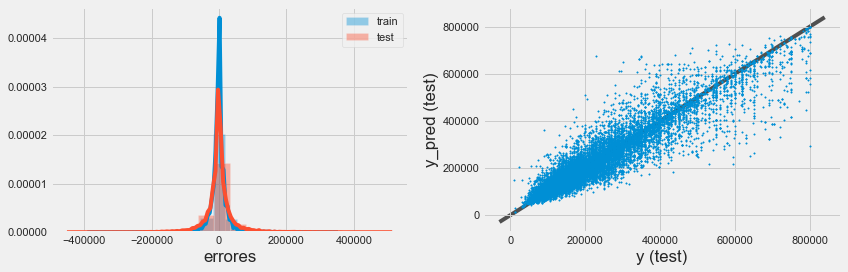

In [184]:
evaluar_regresion(rfr, X_train, X_test, y_train, y_test)

Comparado al benchmark, observamos una reducción de la varianza y del sesgo, producto de la reducción del RMSE en el test, que es el objetivo que perseguimos. Raíz del error cuadrático medio en Test: 42520. Miramos el features importances

In [185]:
importance_rfr = rfr.feature_importances_
importance_rfr

array([0.2859466 , 0.06045758, 0.1275564 , 0.32946172, 0.02223496,
       0.07672249, 0.03366344, 0.06395682])

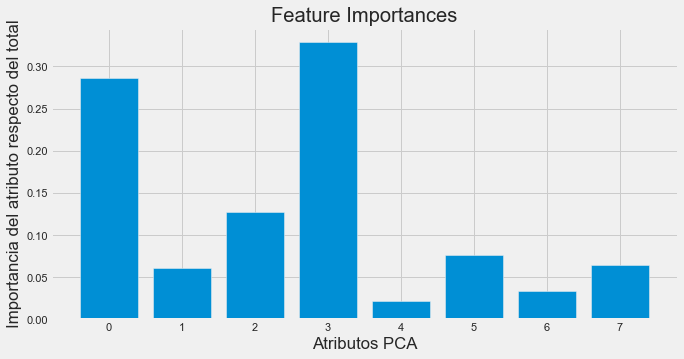

In [186]:
#plot feature importance
plt.figure(figsize = (10,5))
pyplot.bar([x for x in range(len(importance_rfr))], importance_rfr)
plt.title('Feature Importances')
plt.xlabel('Atributos PCA')
plt.ylabel('Importancia del atributo respecto del total')
pyplot.show()

El feature importances es consistente con el modelo benchmark (un sólo arbol). Tres variables explican cerca del 80% de la variabilidad del modelo. Son las únicas tres que superan individualmente el 10%. 

## Regresión con Random Forest, hiperparámetros optimizados

In [187]:
rfr_RS = RandomForestRegressor ()

Para la optimización voy a utilizar un Random Search, debido a la cantidad de hiperparámetros del modelo y de los posibles valores que toma. La mayor ganancia con el Random Forest es mostarle árboles lo más profundos y diferentes posibles. La elección de valores va en ese sentido. Luego explico los hiperparámetros. 

In [188]:
# Grilla para Random Search
random_grid = {'n_estimators': [100, 120, 150, 200, 250, 300, 500],
               'max_depth': [10, 12, 15, 20, 25, 30, None],
               'min_samples_split': [2, 5, 10],
               'max_features': ['auto', 'sqrt'],
               'max_samples': [0.25, 0.50, 0.75]}

In [189]:
model_rfr_RS = RandomizedSearchCV(rfr_RS, random_grid, scoring= 'neg_root_mean_squared_error',
                               n_jobs=-1, random_state=42, cv=5)

In [190]:
model_rfr_RS.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [191]:
print("Mejores parametros: "+str(model_rfr_RS.best_params_))
print("Mejor Score: "+str(model_rfr_RS.best_score_)+'\n')

Mejores parametros: {'n_estimators': 150, 'min_samples_split': 2, 'max_samples': 0.5, 'max_features': 'sqrt', 'max_depth': 20}
Mejor Score: -45776.886664915924



Armo el modelo con los valores surgidos del RandomizedSearchCV 

In [192]:
rfr_opt = RandomForestRegressor (n_estimators = 150, max_depth= 20, min_samples_split= 2, max_samples= 0.5, max_features= 'sqrt',
                                 random_state=42)

In [193]:
rfr_opt.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=0.5, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=150, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

Raíz del error cuadrático medio en Train: 32051.691984008998
Raíz del error cuadrático medio en Test: 43683.7168156187
Coeficiente de Determinación en Train: 0.935812267342631
Coeficiente de Determinación en Test: 0.8811931723161176



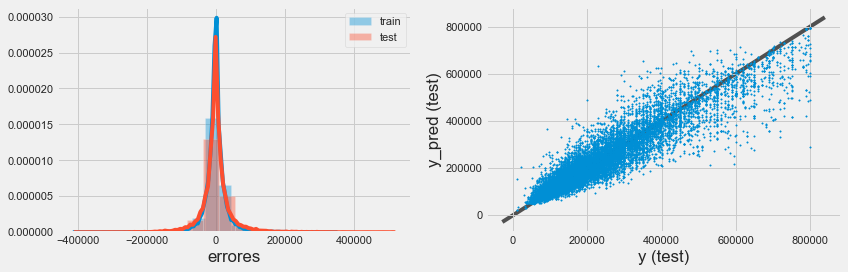

In [194]:
evaluar_regresion(rfr_opt, X_train, X_test, y_train, y_test)

Ahora miramos el feature importances

In [195]:
importance_rfr_opt = rfr_opt.feature_importances_

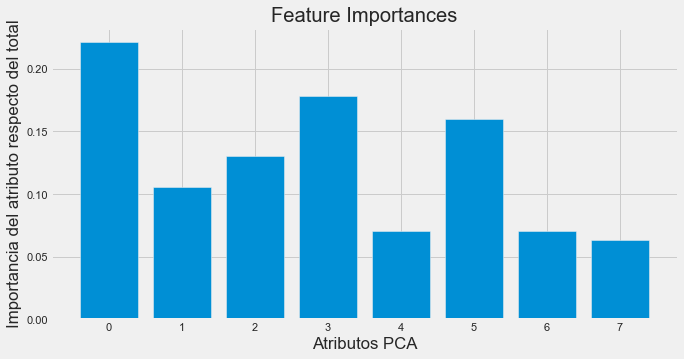

In [196]:
#plot feature importance
plt.figure(figsize = (10,5))
pyplot.bar([x for x in range(len(importance_rfr_opt))], importance_rfr_opt)
plt.title('Feature Importances')
plt.xlabel('Atributos PCA')
plt.ylabel('Importancia del atributo respecto del total')
pyplot.show()    

El Random Forest es un modelo de ensamble de árboles que usa bootstrap y bagging. Necesitamos mostarle árboles lo más profundos y diferente que podamos para sacarle el mejor rendimiento, buscando el balance en el compromiso entre consistencia y precisición. En ese sentido, el modelo que optimizamos con Random Search es el que nos trae la mayor consistencia hasta el momento, resignando mínimamente la precisión al trabajar con los datos de test.

El max samples y max features debemos setearlos con valores <1 para que cada árbol no se entrene con el total de instancias/atributos, justamente, para que sean diversos entre ellos. En el caso de los features, si se los mostrásemos todos, siempre los más importantes quedarían en la parte alta del árbol, con lo cual, los árboles acabarían por ser idénticos. En nuestro caso, el modelo final trabaja con la mitad de las instancias, y con la raíz cuadrada del total de atributos.

El número de estimadores son la cantidad de árboles sembrados. A mayor cantidad de instancias/atributos, necesitamos más árboles, para dar mayor amplitud a la diversidad. Acá finalmente usamos 150 árboles.

El min_samples_split= 2 nos dice que el árbol puede hacer crecer dos hojas diferentes incluso con sólo dos samples (siendo estos diferentes). El max depth=20 es la profundidad máxima que le permitimos. 
 
El Random Forest optimizado por Random Search es un poco menos preciso que el entrenado por defecto, pero más consistente RMSE Train- RMSE Test. Al margen de eso, parece haber un error irreductible en el orden de los 42k-45k por omisión de variable. El modelo tiene heterocedasticidad. Tenemos varianza del error creciente conforme crece el precio de las propiedades.

Ahora miramos el features importances. La importancia de los atributos resulta mejor balanceada que en el benchmark y en el Random Forest entrenado con valores por defecto. Es evidente el efecto en el bagging del cambio en los hiperparámetros. En general, se logró mostrarle árboles aún más diferentes. Hay cinco variables que explican individualmente al menos un 10% de la variabilidad del modelo, y ninguna de las variables explica individualmente menos del 5%.

### Comparación de árboles individuales

In [197]:
rfr_opt.estimators_

[DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=20,
                       max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1608637542, splitter='best'),
 DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=20,
                       max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1273642419, splitter='best'),
 DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=20,
                       max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_de

In [198]:
tree_regressor_1 = DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=20,
                       max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=787716372, splitter='best')
tree_regressor_2 = DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=20,
                       max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=23717335, splitter='best')

In [199]:
tree_regressor_1.fit(X_train, y_train)
tree_regressor_2.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=20,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=23717335, splitter='best')

Modelo: tree_regressor_1
Raíz del error cuadrático medio en Train: 24762.535725909693
Raíz del error cuadrático medio en Test: 49066.841597936414
Coeficiente de Determinación en Train: 0.9616875130186532
Coeficiente de Determinación en Test: 0.850108004693904



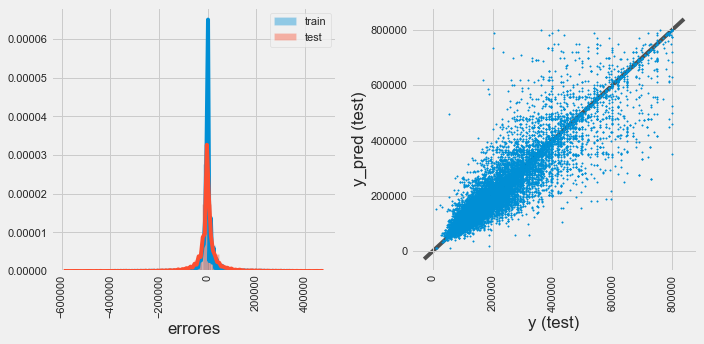

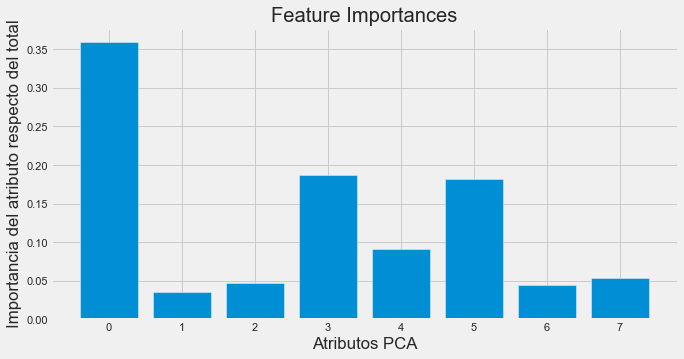

Modelo: tree_regressor_2
Raíz del error cuadrático medio en Train: 25318.49985284389
Raíz del error cuadrático medio en Test: 49477.53501046338
Coeficiente de Determinación en Train: 0.959947829757712
Coeficiente de Determinación en Test: 0.8475882873987687



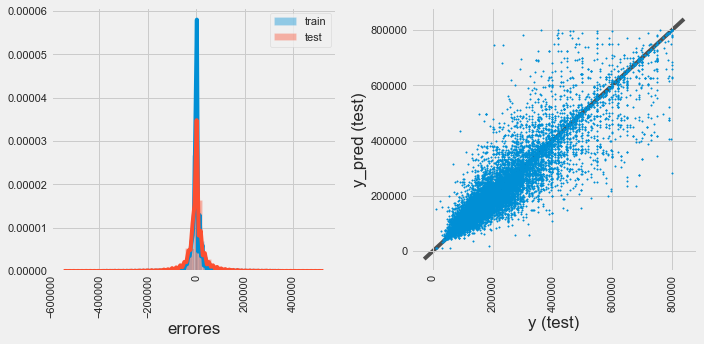

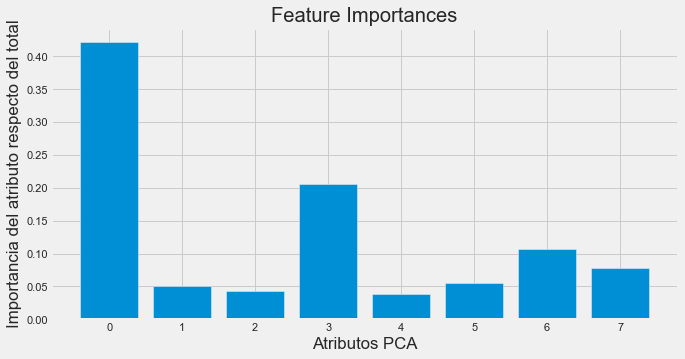

In [200]:
modelos = ['tree_regressor_1', 'tree_regressor_2']
model=['tree_regressor_1', 'tree_regressor_2']

for i, model in enumerate([tree_regressor_1, tree_regressor_2]):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    
    print(f'Modelo: {modelos[i]}')

    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    R2_train = r2_score(y_train, y_train_pred)
    R2_test = r2_score(y_test, y_test_pred)
    print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
    print(f'Raíz del error cuadrático medio en Test: {rmse_test}')
    print(f'Coeficiente de Determinación en Train: {R2_train}')
    print(f'Coeficiente de Determinación en Test: {R2_test}\n')
    
    plt.figure(figsize = (10,5))

    plt.subplot(1,2,1)
    sns.distplot(y_train - y_train_pred, bins = 30, label = 'train')
    sns.distplot(y_test - y_test_pred, bins = 30, label = 'test')
    plt.xticks(rotation = 90)
    plt.xlabel('errores')
    plt.legend()


    ax = plt.subplot(1,2,2)
    ax.scatter(y_test,y_test_pred, s =2)
    
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]
    
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xticks(rotation = 90)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')
    
    plt.tight_layout()
    plt.savefig('Analisis de regresión: Métricas RMSE y R2, benchmark frente a Arbol de decisión y KNN.png', dpi = 400)
    plt.show()
    
    importance_model = model.feature_importances_
    #plot feature importance
    plt.figure(figsize = (10,5))
    pyplot.bar([x for x in range(len(importance_model))], importance_model)
    plt.title('Feature Importances')
    plt.xlabel('Atributos PCA')
    plt.ylabel('Importancia del atributo respecto del total')
    pyplot.show()

Tomamos dos árboles al azar de los que componen el Random Forest optimizado. Ambos muestran errores que evidencian overfitting, que es lo que se buscaba con cada uno de ellos. Menor error en Train, y mayor en test, mostrando menos precisión y menos consistencia.

**Modelo: rfr_opt**
Raíz del error cuadrático medio en Train: 32051.691984008998
Raíz del error cuadrático medio en Test: 43683.7168156187
Coeficiente de Determinación en Train: 0.935812267342631
Coeficiente de Determinación en Test: 0.8811931723161176

**Modelo: tree_regressor_1**
Raíz del error cuadrático medio en Train: 24762.535725909693
Raíz del error cuadrático medio en Test: 49066.841597936414
Coeficiente de Determinación en Train: 0.9616875130186532
Coeficiente de Determinación en Test: 0.850108004693904

**Modelo: tree_regressor_2**
Raíz del error cuadrático medio en Train: 25318.49985284389
Raíz del error cuadrático medio en Test: 49477.53501046338
Coeficiente de Determinación en Train: 0.959947829757712
Coeficiente de Determinación en Test: 0.8475882873987687

En relación al feature importances, se observa que el atributo '0', como en todos los modelos, es el más importante. Sin embargo, la importancia del resto de atributos es muy permeable al set de datos que le es mostrado.

## Otros modelos avanzados

### Bagging_knn

**Entreno modelo de ensamble de KNeighborsRegressor, por defecto y optimizado**

In [201]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor

knn_regressor = KNeighborsRegressor(n_neighbors=3, weights = 'distance', p = 2)
bagging_knn=BaggingRegressor(knn_regressor, random_state=42, n_estimators=30)

In [202]:
bagging_knn.fit(X_train, y_train)

BaggingRegressor(base_estimator=KNeighborsRegressor(algorithm='auto',
                                                    leaf_size=30,
                                                    metric='minkowski',
                                                    metric_params=None,
                                                    n_jobs=None, n_neighbors=3,
                                                    p=2, weights='distance'),
                 bootstrap=True, bootstrap_features=False, max_features=1.0,
                 max_samples=1.0, n_estimators=30, n_jobs=None, oob_score=False,
                 random_state=42, verbose=0, warm_start=False)

Raíz del error cuadrático medio en Train: 26587.014755431046
Raíz del error cuadrático medio en Test: 45667.32782738475
Coeficiente de Determinación en Train: 0.9558338780543967
Coeficiente de Determinación en Test: 0.8701585269940848



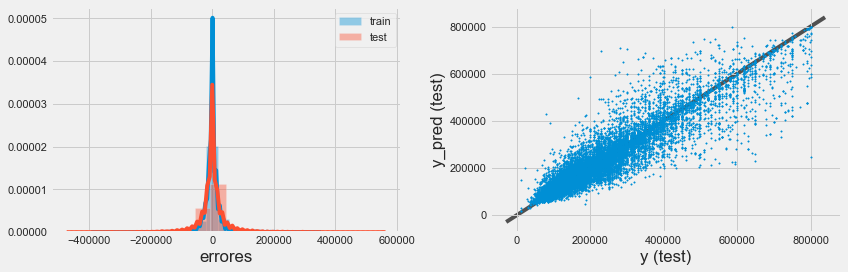

In [203]:
evaluar_regresion(bagging_knn, X_train, X_test, y_train, y_test)

In [204]:
#ESTRATEGIA 2: Random Search
params_bag = {'n_estimators': [50,100, 150, 200, 250, 300], 'max_features':[0.25, 0.5,0.75], 'max_samples': [0.25, 0.5,0.75], 
              'bootstrap_features': ['True', 'False']}


knn_regressor_2= KNeighborsRegressor(n_neighbors=3, weights = 'distance', p = 2)
bagging_knn2=BaggingRegressor(knn_regressor_2, random_state=42, n_estimators=30)

bagging_knn_Opt = RandomizedSearchCV(bagging_knn2, params_bag, n_jobs=-1, random_state=42, cv=5)

bagging_knn_Opt.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=BaggingRegressor(base_estimator=KNeighborsRegressor(algorithm='auto',
                                                                                 leaf_size=30,
                                                                                 metric='minkowski',
                                                                                 metric_params=None,
                                                                                 n_jobs=None,
                                                                                 n_neighbors=3,
                                                                                 p=2,
                                                                                 weights='distance'),
                                              bootstrap=True,
                                              bootstrap_features=False,
                                              max_

In [205]:
print("Mejores parametros: "+str(bagging_knn_Opt.best_params_))
print("Mejor Score: "+str(bagging_knn_Opt.best_score_)+'\n')

Mejores parametros: {'n_estimators': 100, 'max_samples': 0.75, 'max_features': 0.25, 'bootstrap_features': 'False'}
Mejor Score: 0.8634161135840526



In [206]:
BAGGING_KNN_OPT = BaggingRegressor(n_estimators= 200, max_samples= 0.5, max_features= 0.75, 
                                   bootstrap_features= True, n_jobs=-1, random_state=42)
BAGGING_KNN_OPT.fit(X_train, y_train)

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=True,
                 max_features=0.75, max_samples=0.5, n_estimators=200,
                 n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                 warm_start=False)

### XGBOOST

**Entreno modelo de ensamble de árboles y boosting, por defecto y optimizado**

[10:33:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Raíz del error cuadrático medio en Train: 60463.64980609541
Raíz del error cuadrático medio en Test: 60393.27287351564
Coeficiente de Determinación en Train: 0.771577525199779
Coeficiente de Determinación en Test: 0.772919749188624



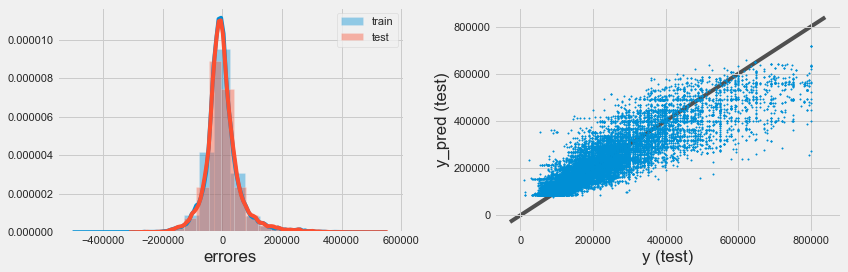

In [207]:
import xgboost
from xgboost import XGBRegressor


XGB = XGBRegressor()

XGB.fit(X_train, y_train)
evaluar_regresion(XGB, X_train, X_test, y_train, y_test)

In [208]:
#ESTRATEGIA 2: Random Search
params_XGB ={"learning_rate": [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
            "max_depth": [3, 4, 5, 6, 8, 10, 12, 15],
            "min_child_weight": [1, 3, 5, 7],
            "gamma": [0.0, 0.1, 0.2, 0.3, 0.4],
            "colsample_bytree": [0.3, 0.4, 0.5, 0.7]}

XGB_2 = XGBRegressor()
XGB_Opt = RandomizedSearchCV(XGB_2, params_XGB, n_jobs=-1, random_state=42, cv=5)

#Entrenamos:
XGB_Opt.fit(X_train, y_train)

print("Mejores parametros: "+str(XGB_Opt.best_params_))
print("Mejor Score: "+str(XGB_Opt.best_score_)+'\n')

[10:35:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mejores parametros: {'min_child_weight': 1, 'max_depth': 15, 'learning_rate': 0.2, 'gamma': 0.4, 'colsample_bytree': 0.7}
Mejor Score: 0.8734360909890689



In [209]:
XGBRegressor().get_params().keys()

dict_keys(['base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'gamma', 'importance_type', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'n_estimators', 'n_jobs', 'nthread', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'seed', 'silent', 'subsample', 'verbosity'])

In [210]:
XGBOOST_OPT = XGBRegressor(min_child_weight= 3, max_depth= 10, learning_rate= 0.2, gamma= 0.3, 
                           colsample_bytree= 0.4, n_jobs=-1, random_state=42)
XGBOOST_OPT.fit(X_train, y_train)

[10:35:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0.3,
             importance_type='gain', learning_rate=0.2, max_delta_step=0,
             max_depth=10, min_child_weight=3, missing=None, n_estimators=100,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

## Comparativa general entre árbol benchmark y modelos avanzados optimizados (Random Forest, Baggin_KNN, XGBOOST)

Modelo: Árbol de Decisión Benchmark
Raíz del error cuadrático medio en Train: 25974.11708309157
Raíz del error cuadrático medio en Test: 48944.44318242847
Coeficiente de Determinación en Train: 0.9578466881158494
Coeficiente de Determinación en Test: 0.8508548903372507



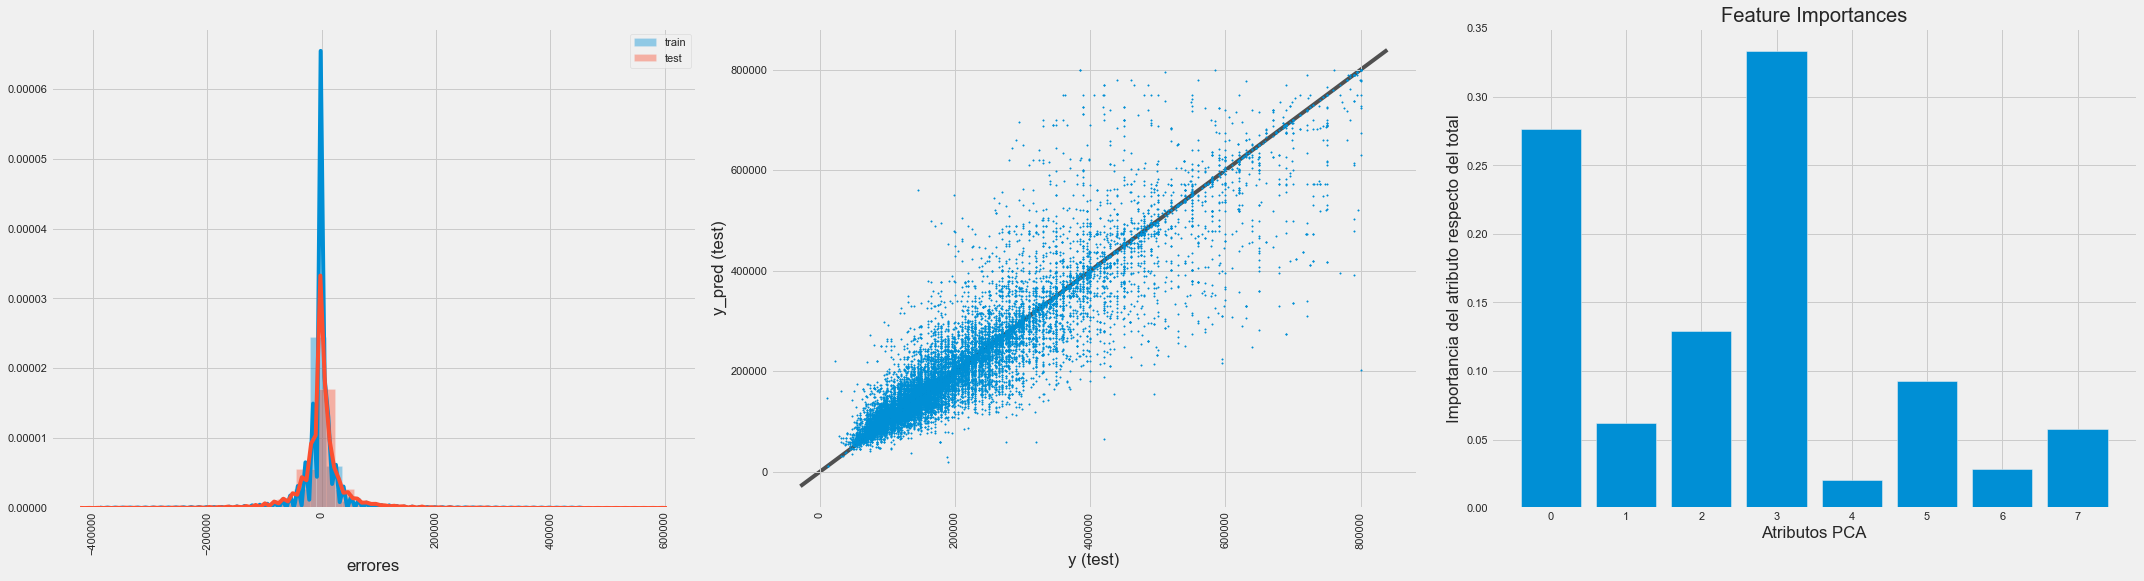

Modelo: Random Forest
Raíz del error cuadrático medio en Train: 32051.691984008998
Raíz del error cuadrático medio en Test: 43683.7168156187
Coeficiente de Determinación en Train: 0.935812267342631
Coeficiente de Determinación en Test: 0.8811931723161176



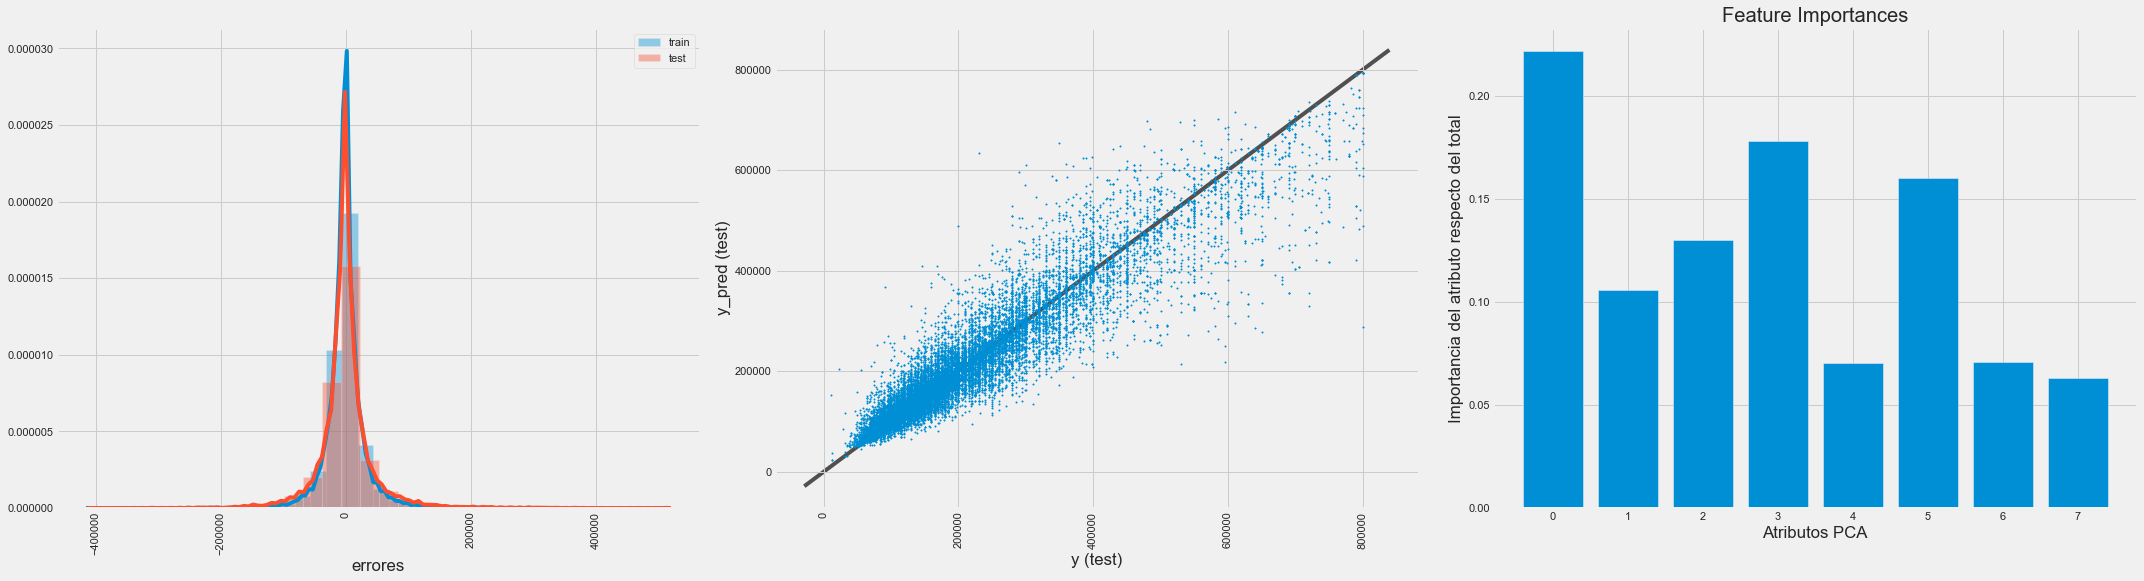

Modelo: Bagging KNN
Raíz del error cuadrático medio en Train: 31059.831314441122
Raíz del error cuadrático medio en Test: 43206.038839335466
Coeficiente de Determinación en Train: 0.9397234621366503
Coeficiente de Determinación en Test: 0.8837772527504861



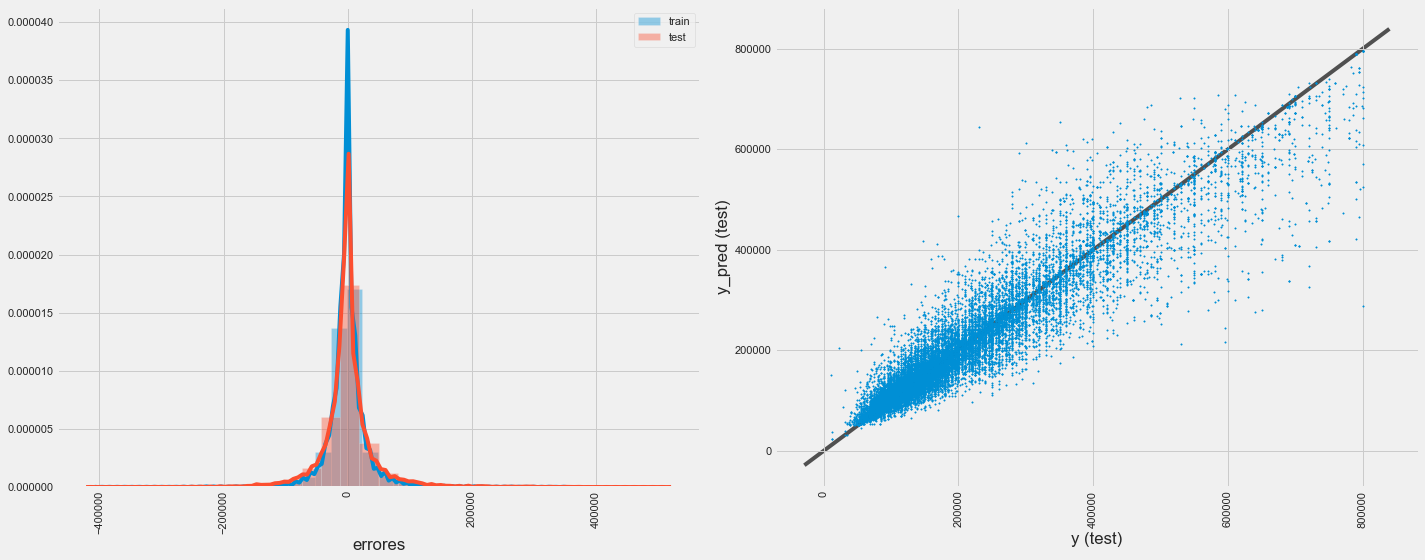

Modelo: XGBoost
Raíz del error cuadrático medio en Train: 36161.21117314542
Raíz del error cuadrático medio en Test: 44736.794297859546
Coeficiente de Determinación en Train: 0.9182973674130168
Coeficiente de Determinación en Test: 0.8753960083907112



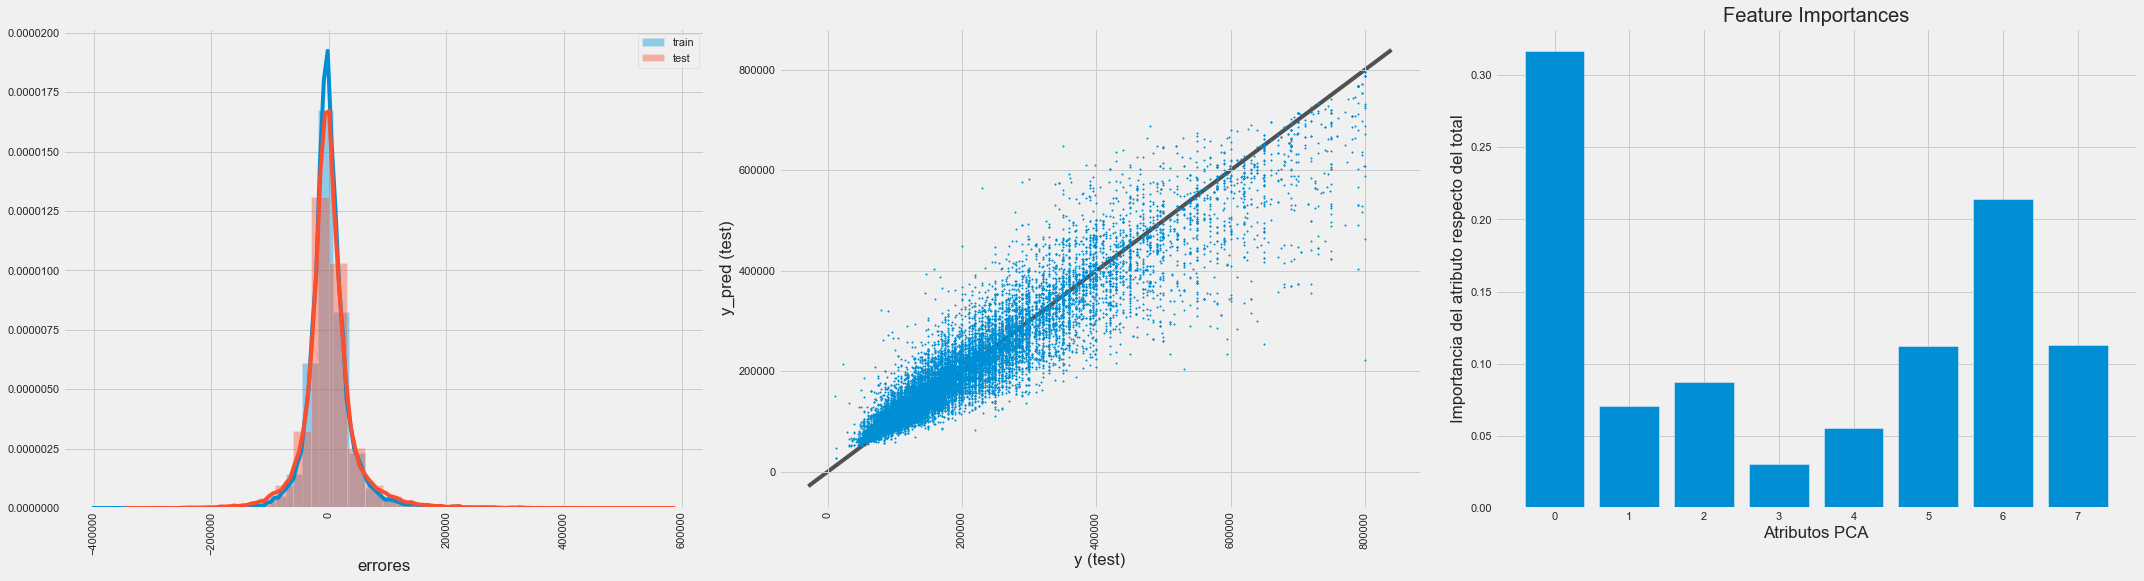

In [211]:
modelos = ['Árbol de Decisión Benchmark', 'Random Forest', 'Bagging KNN', 'XGBoost']


for i, model in enumerate([tree_regressor, rfr_opt, BAGGING_KNN_OPT, XGBOOST_OPT]):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    
    print(f'Modelo: {modelos[i]}')

    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    R2_train = r2_score(y_train, y_train_pred)
    R2_test = r2_score(y_test, y_test_pred)
    print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
    print(f'Raíz del error cuadrático medio en Test: {rmse_test}')
    print(f'Coeficiente de Determinación en Train: {R2_train}')
    print(f'Coeficiente de Determinación en Test: {R2_test}\n')
    
    plt.figure(figsize = (10*3,8))

    plt.subplot(1,3,1)
    sns.distplot(y_train - y_train_pred, bins = 30, label = 'train')
    sns.distplot(y_test - y_test_pred, bins = 30, label = 'test')
    plt.xticks(rotation = 90)
    plt.xlabel('errores')
    plt.legend()


    ax = plt.subplot(1,3,2)
    ax.scatter(y_test,y_test_pred, s =2)
    
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]
    
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xticks(rotation = 90)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')
    
    plt.tight_layout()
    
    if model != BAGGING_KNN_OPT:
        plt.subplot(1,3,3)
        importance_model = model.feature_importances_
        #plot feature importance
        #plt.figure(figsize = (10,5))
        pyplot.bar([x for x in range(len(importance_model))], importance_model)
        plt.title('Feature Importances')
        plt.xlabel('Atributos PCA')
        plt.ylabel('Importancia del atributo respecto del total')
        pyplot.show()
    else:
        plt.show()   

Baggin KNN y Random Forest, modelos de ensamble, arrojan los mejores (y muy similares) valores de error. En el caso de Baggin KNN, es un modelo que ensambla KNeighborsRegressor, es decir, se basa en distancias. Evidentemente funciona muy bien a raíz del preprocesamiento que realizamos a los datos. Los hiperparámetros del bagging knn no los expliqué porque son idénticos a los del random. En el caso del KNeighborsRegressor uso n_neighbors=3, realizo ponderación por distancia, y distancia euclidiana. 

Observo que los errores de los modelos se distribuyen normalmente en torno a cero, pero hay heterocedasticidad a mayores precios de las propiedades. Aún faltan incluir atributos que nos ayuden a explicar los mayores precios, obtener más datos (sobre todo de propiedades de alto valor), o mejorar el preprocesamiento. De todos modos, la mejora frente a los resultados del Proyecto_01 es notable. Un R2 de 0.88 en Test creo que es un excelente valor, pero el error, monetizandolo mediante el RMSE, es aún importante.